# Preliminary modelling for Borrellia

First, we load all packages and data. 

In [66]:
######## GAM model with manual hurdle component ##########
library(tidyverse)
library(pscl) # hurdle models
library(lme4) # mixed effect models
library(boot) # logit/inv logit
library(car) # Anova (type III)
library(mgcv) # for GAMs
library(randomForest) # for random forest
library(brms)

tck <- read.csv("data_derived/MASTER_all_tck_data_merged.csv")


Loading required package: Rcpp
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Loading 'brms' package (version 2.12.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

Attaching package: ‘brms’

The following objects are masked from ‘package:mgcv’:

    s, t2

The following object is masked from ‘package:lme4’:

    ngrps

The following object is masked from ‘package:stats’:

    ar



## Filtering dataset 

First, let's see how many plots were tested and how many times (number of tests)

In [2]:
#### Filter tick dataset and adjust ####

## How many plots were tested, and how many times?
tck %>%
  mutate(tested=ifelse(is.na(testingID),"no","yes")) %>%
  select(plotID, tested) %>% table(useNA="ifany")


          tested
plotID        no   yes
  ABBY_001    70     0
  ABBY_002    63     0
  ABBY_003    63     0
  ABBY_005    67     0
  ABBY_006    63     0
  ABBY_023    68     0
  BARR_021     3     0
  BARR_030     9     0
  BARR_031     9     0
  BARR_034     9     0
  BARR_037     9     0
  BARR_084     9     0
  BART_002    93     0
  BART_010    87     0
  BART_011    87     0
  BART_015    90     0
  BART_019    87     0
  BART_029    66     0
  BLAN_002   180     0
  BLAN_004   123     0
  BLAN_005  2193  2807
  BLAN_008   126     0
  BLAN_012   221     6
  BLAN_015   798     2
  BLAN_020     3     0
  BONA_002    15     0
  BONA_004    12     0
  BONA_012    15     0
  BONA_013    12     0
  BONA_020    12     0
  BONA_044    15     0
  CLBJ_032    87     0
  CLBJ_033    91     0
  CLBJ_034    87     0
  CLBJ_036    81     0
  CLBJ_040    87     0
  CLBJ_043    87     0
  CPER_001    66     0
  CPER_002    66     0
  CPER_003    66     0
  CPER_004    66     0
  CPER_005    66 

In [5]:
tck %>%
  mutate(tested=ifelse(is.na(testingID),"no","yes")) %>%
  select(lifeStage, tested) %>% table(useNA="ifany")

         tested
lifeStage     no    yes
    Adult   9815      0
    Larva 260512      0
    Nymph  13821 155154

There are many plots that are never tested, and only nymphs were ever tested. Additionally, we are really only interested in Borrelia, since this causes Lyme disease. Let's look at the distribution of negative-Borrelia and non-tested sites. First, aggregate the dataset so that each line is ONE SAMPLE that tells us number tested, proportion tested, etc

In [3]:
## Filter tck to only include samples that tested Borrelia_sp.; count number of different life stages; create proportiontested/positive tc
tck_allsamples_borr <- tck %>%
  mutate(tested=ifelse(is.na(Borrelia_sp.),0,1) # Was each tick  ever tested for borrellia?
         ,isPositive=ifelse(Borrelia_sp.=="Positive", 1,0) # And if it was tested, was it positive or negative?
  ) %>%
  group_by(domainID, siteID, nlcdClass, plotID, elevation, collectDate, dayOfYear, year, month) %>% # collapse by sample-- summing all tck counts together
  summarize(numberTested=sum(tested, na.rm=TRUE) # number of tested ticks in that sample
            ,n=n() # total ticks in that sample
            , numberPositive=sum(isPositive,na.rm = TRUE) # number of positive ticks in that sample
            , nAdult=sum(lifeStage=="Adult")
            , nNymph=sum(lifeStage=="Nymph")
            , nLarva=sum(lifeStage=="Larva")) %>%
  ungroup() %>%
  mutate(proportionTested=numberTested/nNymph # proportion of all nymph ticks tested-- only nymphs were ever tested.
         , proportionPositive=numberPositive/numberTested
         , tested = ifelse(numberTested > 0 , TRUE, FALSE) # new true/false tested, which is summed across ticks
         , testingStatus = ifelse(numberTested > 0, "Tested", ifelse(nNymph>0, "Nymphs present, not tested", "No nymphs"))
         ) %>%
  mutate(nlcdClass=factor(nlcdClass, levels=c("emergentHerbaceousWetlands","cultivatedCrops","pastureHay","grasslandHerbaceous"
                                              ,"dwarfScrub","shrubScrub","sedgeHerbaceous"
                                              ,"woodyWetlands","deciduousForest","evergreenForest","mixedForest"))) %>%
  mutate(borrPresent = ifelse(numberPositive>0,1,0)
         , domainID = factor(as.character(domainID))
         , siteID = factor(as.character(siteID))
         , plotID = factor(as.character(plotID))
         , year = factor(year)
         , tckDensity = sum(c(nLarva, nNymph, nAdult))/n
         , ntckDensity = nNymph/n
         , NLtckDensity = sum(c(nNymph, nAdult), na.rm = TRUE)/n)  %>%
  mutate(lognymphDensity=log(ntckDensity) # Log nymph density
         , logNLtckDensity=log(NLtckDensity) # Log non-Larval density (nymph + adults)
         , logtckDensity = log(tckDensity)) # Log total tick density

 Now, let's look at our data and see the degree of zero-inflation there is:

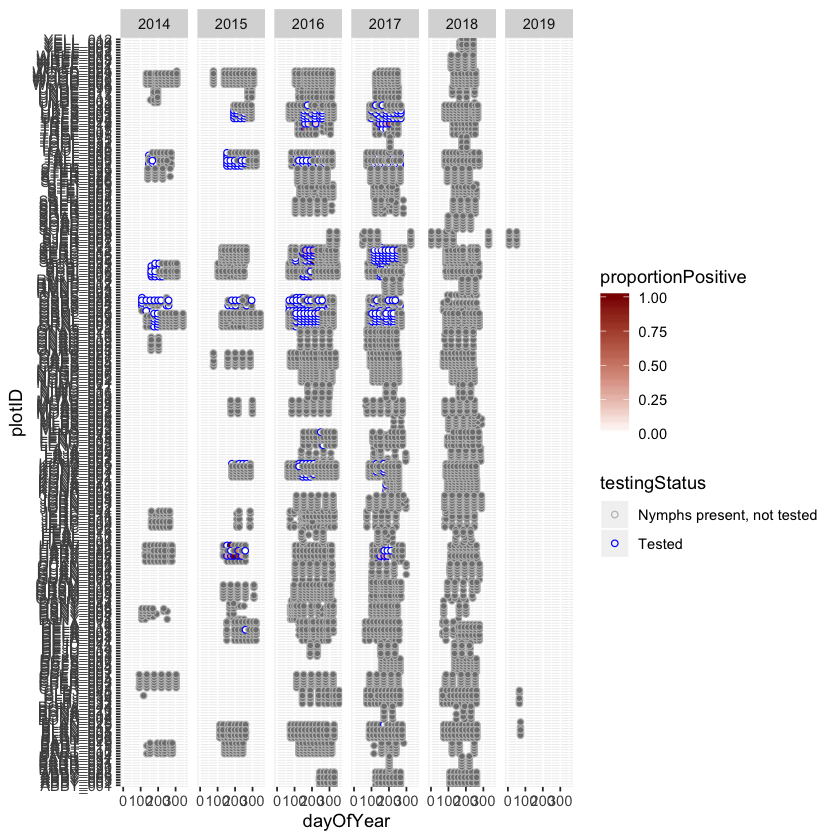

In [4]:
## Plot over time, by year, by plot, to see how zero-inflated it is.
tck_allsamples_borr %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=plotID, fill=proportionPositive, col=testingStatus), pch=21) +
  scale_fill_gradient(low="white", high="darkred") +
  scale_color_manual(values=c(Tested="blue", `Nymphs present, not tested`="grey", `No nymphs`="white")) +
  facet_grid(.~year)

What we see is that there are many plots where there were never tested, even though nymphs were present. Therefore, we should remove those sites from analyses.

In [6]:
# What plots never had any borrelia?
infectedPlots <- tck %>%
  filter(Borrelia_sp.=="Positive") %>%
  select(plotID) %>%pull() %>% unique()
## Filtering same data as above; only now removing non-infected plots.
tck_borrelia_positivePlots <- tck_allsamples_borr %>%
  filter(plotID %in% as.character(infectedPlots))

Now, we can look at the distribution of zeros across all plots that were tested at least once.

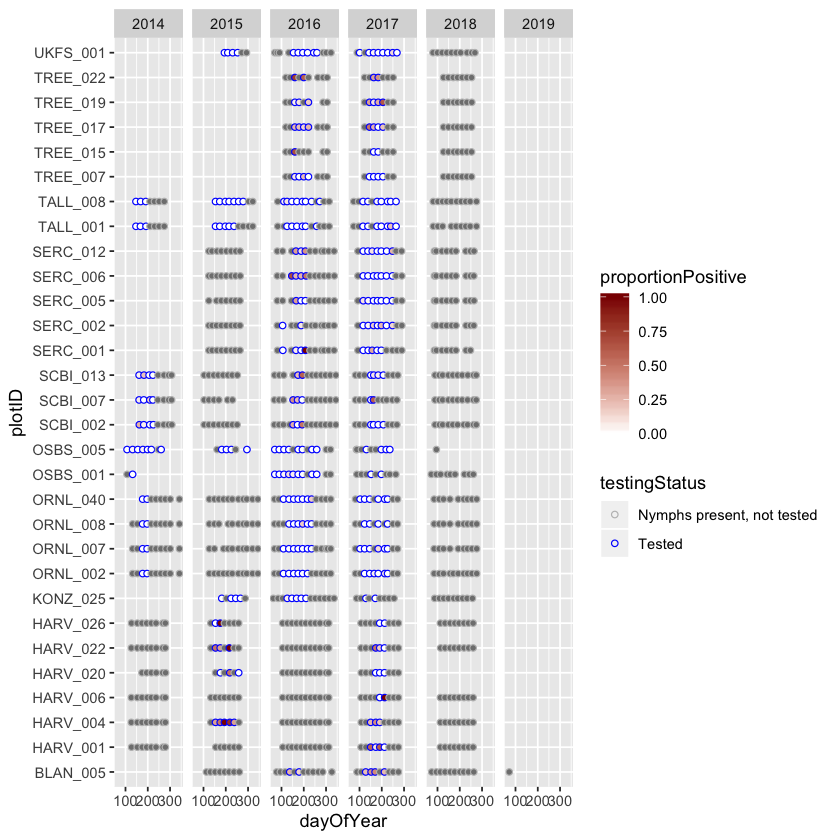

In [7]:
tck_borrelia_positivePlots %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=plotID, fill=proportionPositive, col=testingStatus), pch=21) +
  scale_fill_gradient(low="white", high="darkred") +
  scale_color_manual(values=c(Tested="blue", `Nymphs present, not tested`="grey", `No nymphs`="white")) +
  facet_grid(.~year)


There are a lot of plot:collectionDate combinations that were simply never nested. So, let's remove those as well and re-plot the samples.

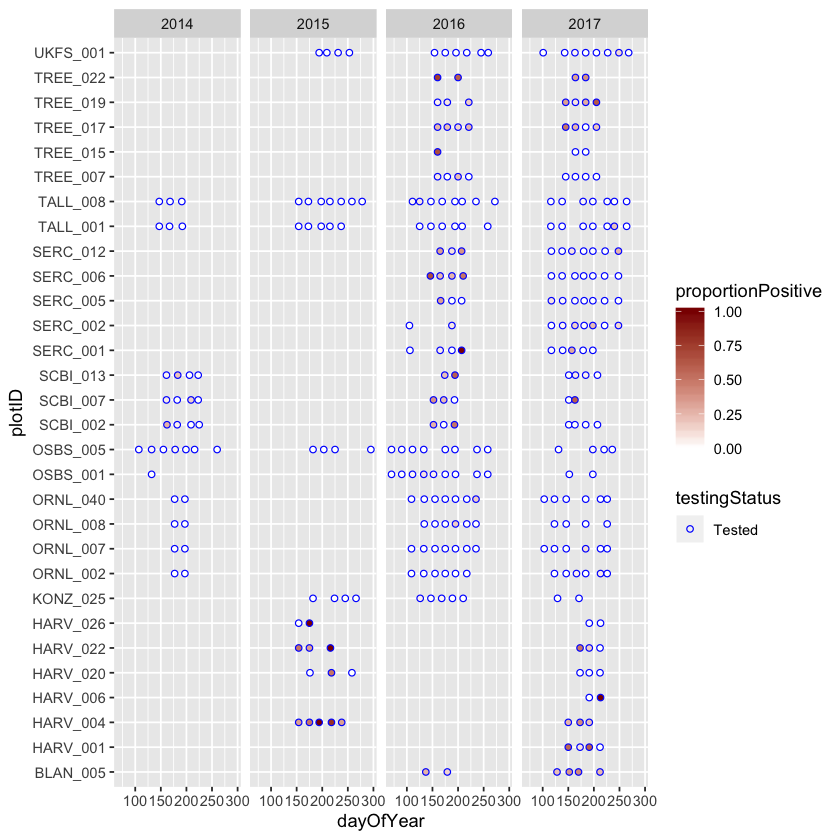

In [8]:
## There are STILL a lot of zeros-- zeros where there are nymphs but they were never tested.
## Let's remove those.
tck_borrelia <- tck_borrelia_positivePlots %>%
  mutate(numberPositive=ifelse(numberTested==0,NA,numberPositive)) %>% # Make sure that numberPositive is not artificially zero-- if there were no tests, it should be NA
  filter(numberTested!=0) # get rid of all samples where the didn't actually test.

tck_borrelia %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=plotID, fill=proportionPositive, col=testingStatus), pch=21) +
  scale_fill_gradient(low="white", high="darkred") +
  scale_color_manual(values=c(Tested="blue", `Nymphs present, not tested`="grey", `No nymphs`="white")) +
  facet_grid(.~year)

What we have are 311 samples left (see code below), where there is still an inflation of zeros, but is much, much better than before.


In [ ]:
nrow(tck_borrelia)
# There are only 311 samples left-- still zero inflated, but slightly better.


## Preliminary Plotting of prevalence and count

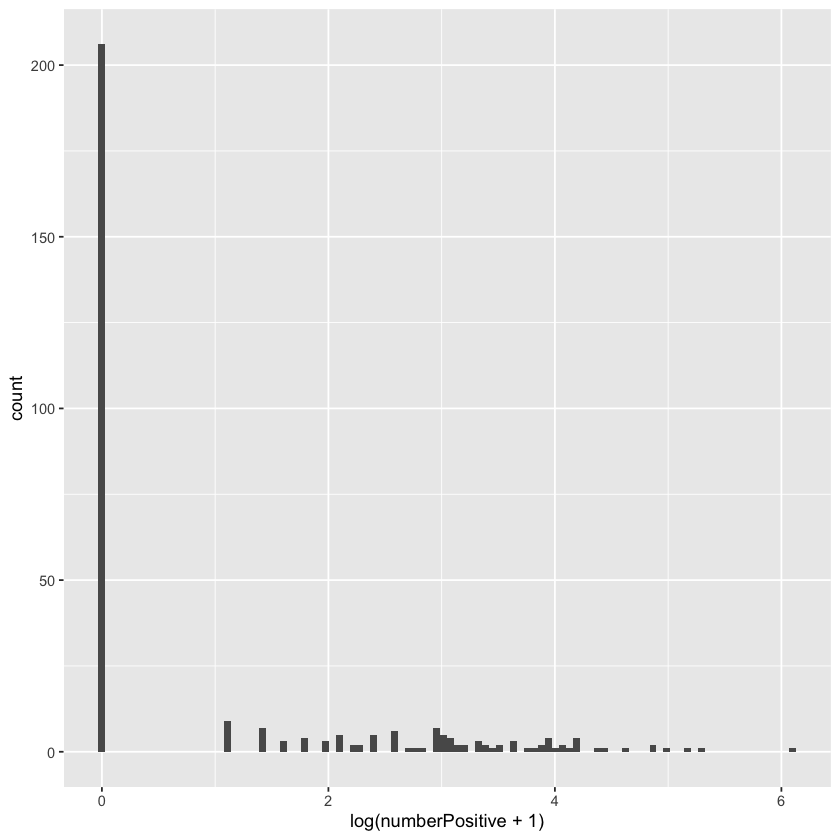

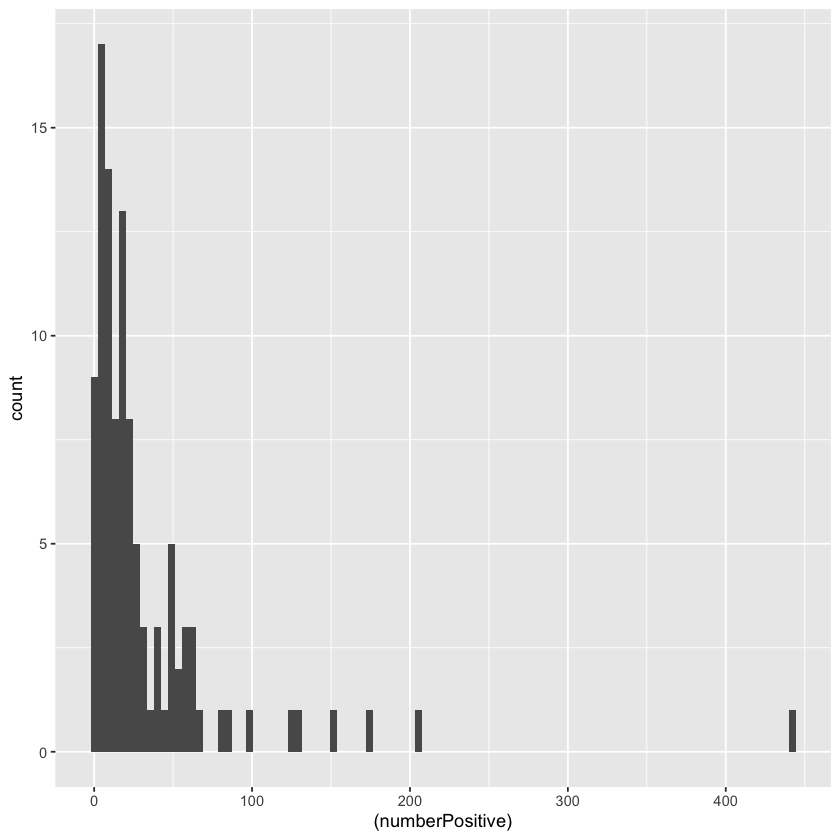

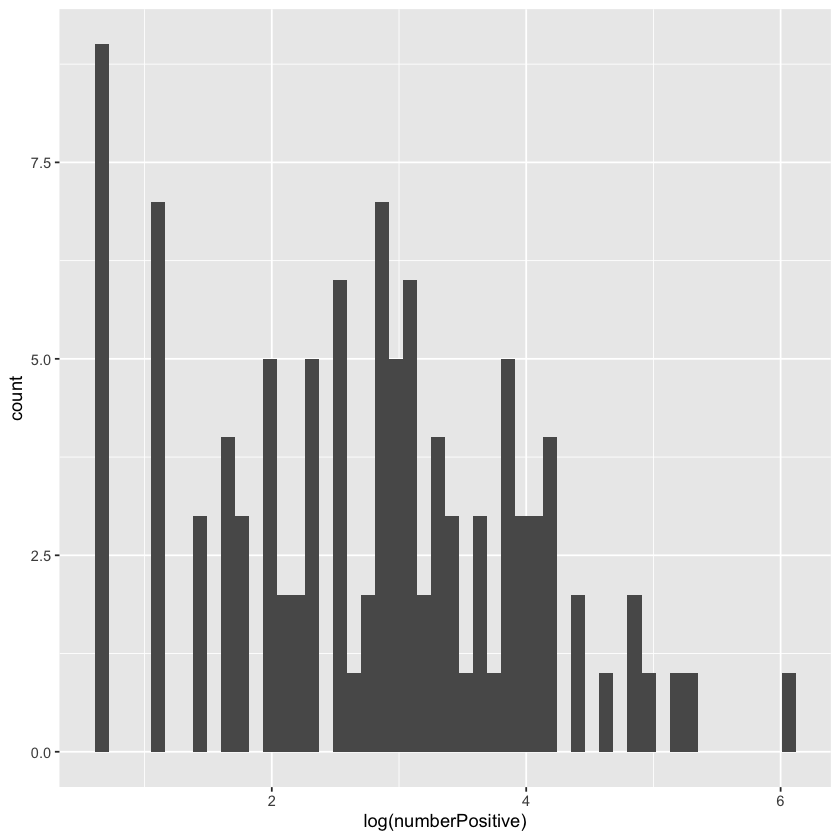

In [9]:
#### Preliminary Plotting ####

# First, what is the distribution of Borrelia prevalence?
tck_borrelia %>%
  ggplot() +geom_histogram(aes(x=log(numberPositive+1)), bins=100)
# histogram without any zeros
tck_borrelia %>%
  filter(numberPositive>0) %>%
  ggplot() +geom_histogram(aes(x=(numberPositive)), bins=100)
# histogram log abundance, no zeros
tck_borrelia %>%
  filter(numberPositive>0) %>%
  ggplot() +geom_histogram(aes(x=log(numberPositive)), bins=50)


Are the number of positive ticks proportional to infection prevalence?

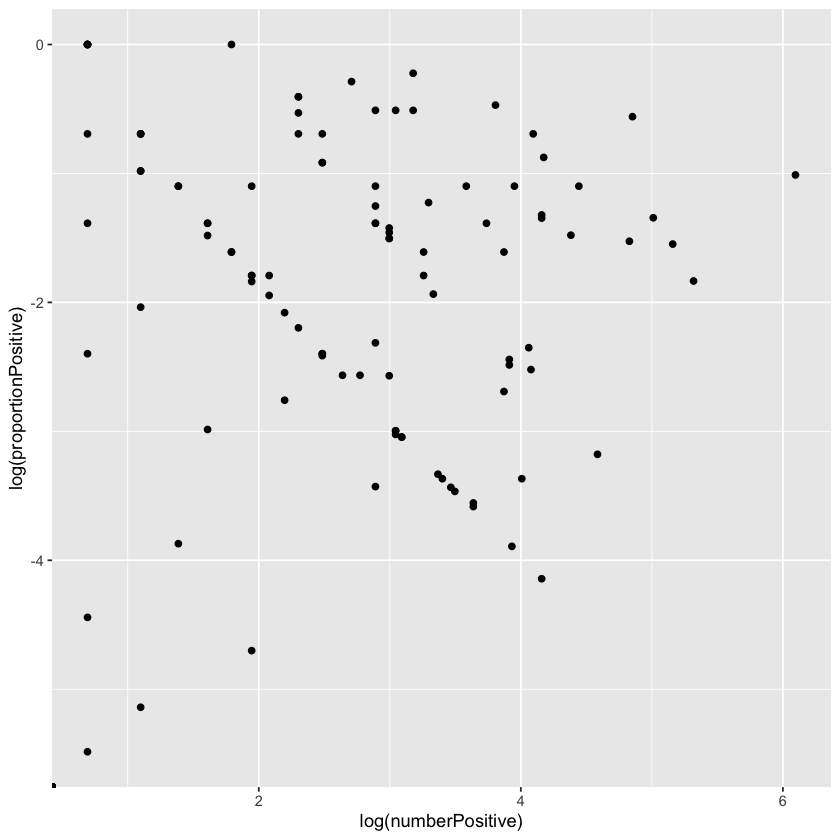

In [10]:
# What is relationship between proportion positive and number positive
tck_borrelia %>%
  ggplot() +geom_point(aes(x=log(numberPositive), y=log(proportionPositive)))

What proportion of nymphs were tested in each sample? We expect a 1:1 line below if all nymphs were tested within each sample.


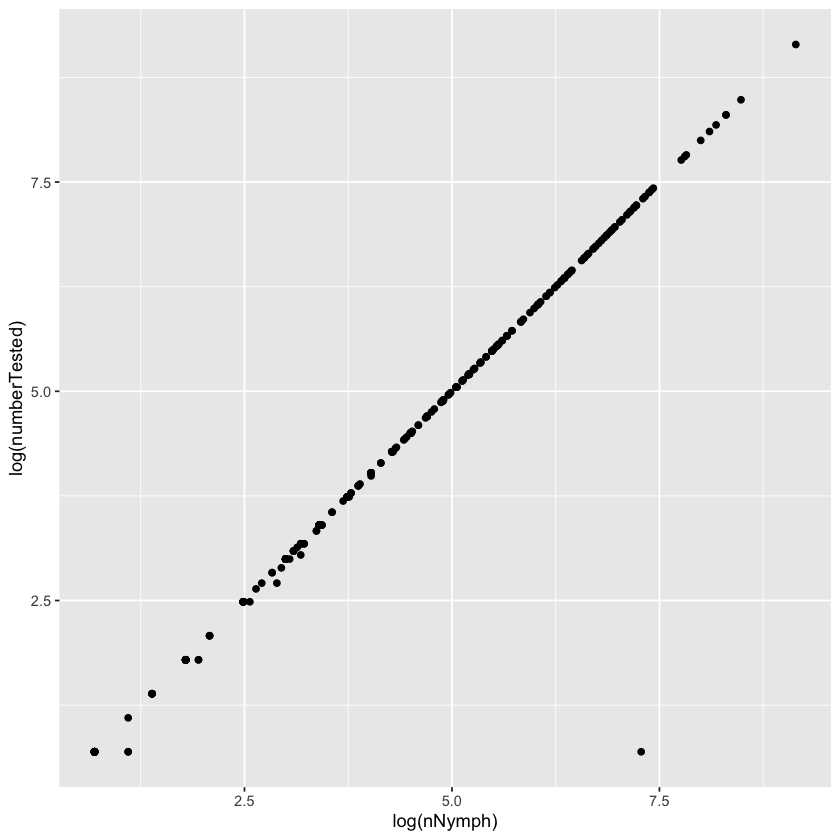

In [11]:
# Now, what is the relationship between number tested and nNymph? Might be a binning artifact?
tck_borrelia %>%
  ggplot() +geom_point(aes(x=log(nNymph), y=log(numberTested)))

There are a few samples where they did not test ALL the nymphs. If we inspect these (below), we see that only HARV_004 is concerning, since all the others are missing less than 3 nymphs in their testing.

In [12]:
# Just get rid of all data where they didn't test most nymphs-- see how many that is
tck_borrelia %>%
  filter(abs(nNymph-numberTested)>0) %>% select(plotID, collectDate, nNymph, numberTested)
# Most of these samples are not a problem, except HARV_004 (2015) and maybe SCI_002 (2017) and SERC_001 (2017-07). 
# Let's get rid of only HARV_004; I think all the rest are fine.
tck_borrelia_adj <- tck_borrelia %>%
  filter(abs(nNymph-numberTested)<3) # HARV_004 is the only site that differs nNymph and numberTested by more than 3


plotID   collectDate       nNymph numberTested
1  HARV_004 2015-07-13T18:22Z 1451      2        
2  BLAN_005 2016-05-16T15:37Z  577    575        
3  BLAN_005 2017-06-01T17:59Z 1222   1221        
4  BLAN_005 2017-06-19T14:51Z  158    156        
5  SCBI_002 2016-05-31T14:40Z  241    240        
6  SCBI_002 2017-07-03T16:34Z    7      6        
7  SCBI_007 2017-05-31T17:32Z   13     12        
8  SCBI_013 2017-07-26T17:29Z  483    482        
9  SERC_001 2017-06-28T15:00Z   31     30        
10 SERC_001 2017-07-17T20:38Z    7      6        
11 SERC_002 2017-04-27T18:58Z    3      2        
12 SERC_002 2017-08-09T17:57Z   29     28        
13 SERC_005 2016-06-14T14:38Z   56     54        
14 SERC_005 2017-06-30T12:09Z   29     28        
15 SERC_005 2017-07-17T18:56Z   25     24        
16 SERC_006 2016-05-25T12:27Z   18     15        
17 SERC_006 2017-06-12T15:10Z  341    340        
18 SERC_006 2017-08-09T16:33Z    3      2        
19 SERC_012 2016-06-13T18:25Z   24     21        
20 SERC_012 2017-05-18T23:10Z  133    132        
21 SERC_012 2017-06-29T21:15Z   25     24        
22 OSBS_005 2016-03-30T13:40Z 3578   3577        
23 TREE_019 2016-06-27T17:45Z  576    575        
24 ORNL_002 2016-07-13T14:40Z   31     30        
25 ORNL_002 2017-05-03T14:15Z  133    132        
26 ORNL_007 2014-07-16T16:50Z  183    182        
27 ORNL_007 2016-06-03T15:00Z   73     72        
28 ORNL_007 2016-07-13T04:53Z 1600   1599        
29 ORNL_007 2017-04-13T16:05Z   19     18        
30 ORNL_007 2017-05-26T19:11Z   43     42        
31 ORNL_007 2017-07-03T16:07Z   91     90        
32 ORNL_007 2017-08-01T16:44Z   21     20        
33 ORNL_008 2014-06-26T15:32Z 4033   4032        
34 ORNL_008 2017-05-26T17:25Z  183    182        
35 ORNL_040 2017-08-01T13:19Z  625    624        
36 TALL_008 2016-04-20T15:23Z  871    870

## Fitting GAMs

Because the data are zero-inflated, we are going to do a two-part model first to prevent issues with convergence. First, we fit a GAM to the binomial component of the data.

In [13]:
#### Fitting GAMs with a hurdle model component ####

# First, model a binomial component with dayOfYear, nlcdClass, and non-larval tick density (NLtckDensity) as predictors of borrellia presence/absence.
# Plot is a random effect, which I include as a varying-intercept, varying-slope model.
mod.gambin <- gam(borrPresent ~ s(dayOfYear) + nlcdClass + s(plotID, bs="re") + s(dayOfYear,plotID, bs="re") + s(logNLtckDensity) + offset(log(numberTested))
                # , offset=log(numberTested) # I include the offset in the formula instead, so that it is included in predictions. Including it here does NOT incorporate numberTested in predictiosn.
                , data=tck_borrelia_adj
                , method="REML"
                , family=binomial)



Method: REML   Optimizer: outer newton
full convergence after 9 iterations.
Gradient range [-0.0002481739,-3.069898e-05]
(score 150.2897 & scale 1).
Hessian positive definite, eigenvalue range [5.50818e-05,3.265953].
Model rank =  82 / 82 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                       k'   edf k-index p-value
s(dayOfYear)         9.00  1.01    0.93    0.15
s(plotID)           30.00 15.00      NA      NA
s(dayOfYear,plotID) 30.00  5.92      NA      NA
s(logNLtckDensity)   9.00  1.00    1.03    0.70


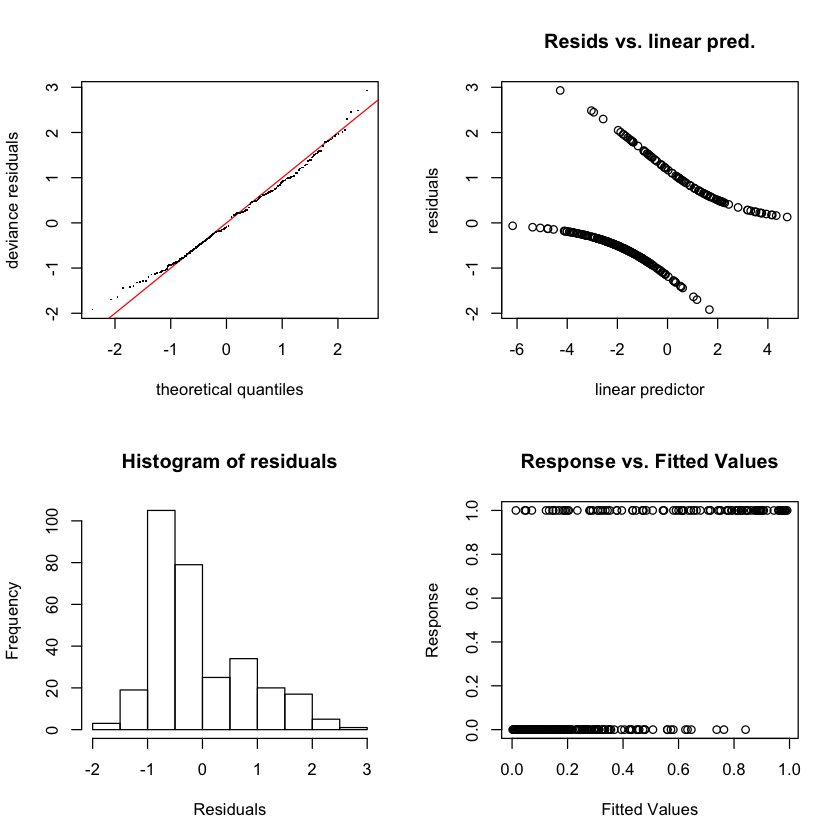

In [14]:
gam.check(mod.gambin)


In [15]:
summary(mod.gambin)



Family: binomial 
Link function: logit 

Formula:
borrPresent ~ s(dayOfYear) + nlcdClass + s(plotID, bs = "re") + 
    s(dayOfYear, plotID, bs = "re") + s(logNLtckDensity) + offset(log(numberTested))

Parametric coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -6.046      1.137  -5.316 1.06e-07 ***
nlcdClassdeciduousForest    1.165      1.217   0.957   0.3385    
nlcdClassevergreenForest    2.339      1.570   1.490   0.1364    
nlcdClassmixedForest        4.876      1.899   2.568   0.0102 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                       edf Ref.df Chi.sq  p-value    
s(dayOfYear)         1.013  1.026   3.55   0.0602 .  
s(plotID)           15.003 26.000  67.52   0.1576    
s(dayOfYear,plotID)  5.923 29.000  32.84   0.3815    
s(logNLtckDensity)   1.000  1.000  16.19 5.73e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ 

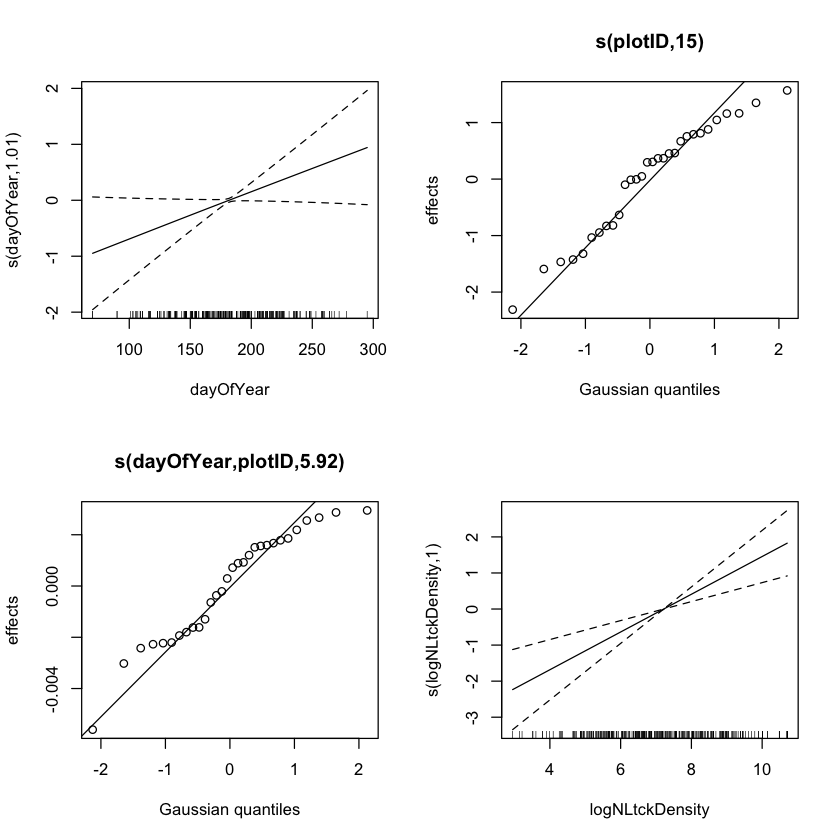

In [16]:
plot(mod.gambin, scale=0, pages=1)


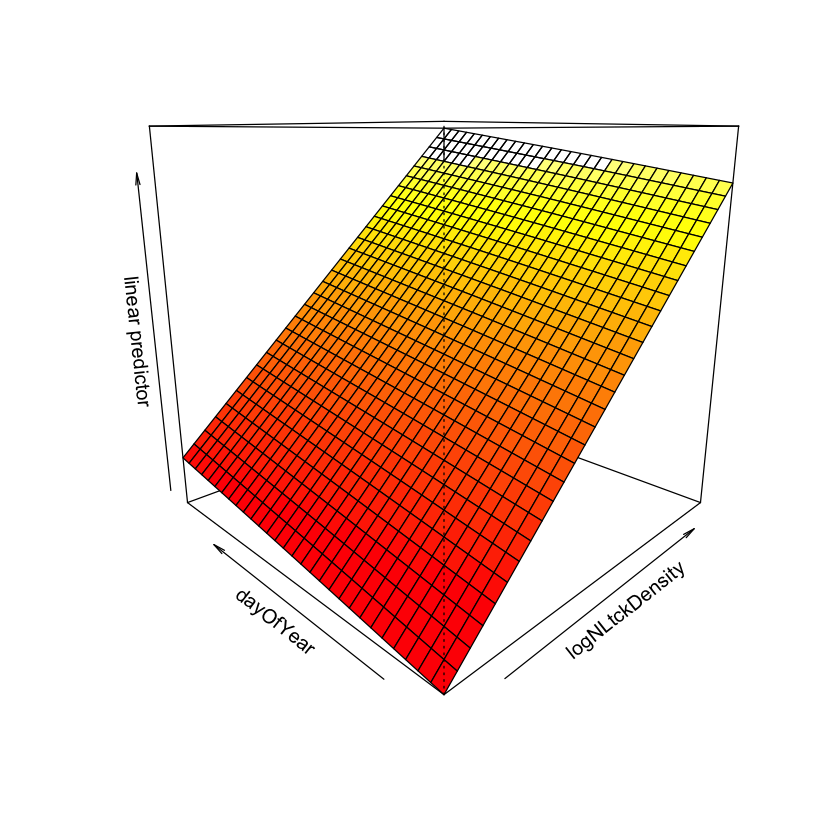

In [17]:
vis.gam(mod.gambin, view = c("logNLtckDensity","dayOfYear"), theta=-45)


[1] 0.8441558

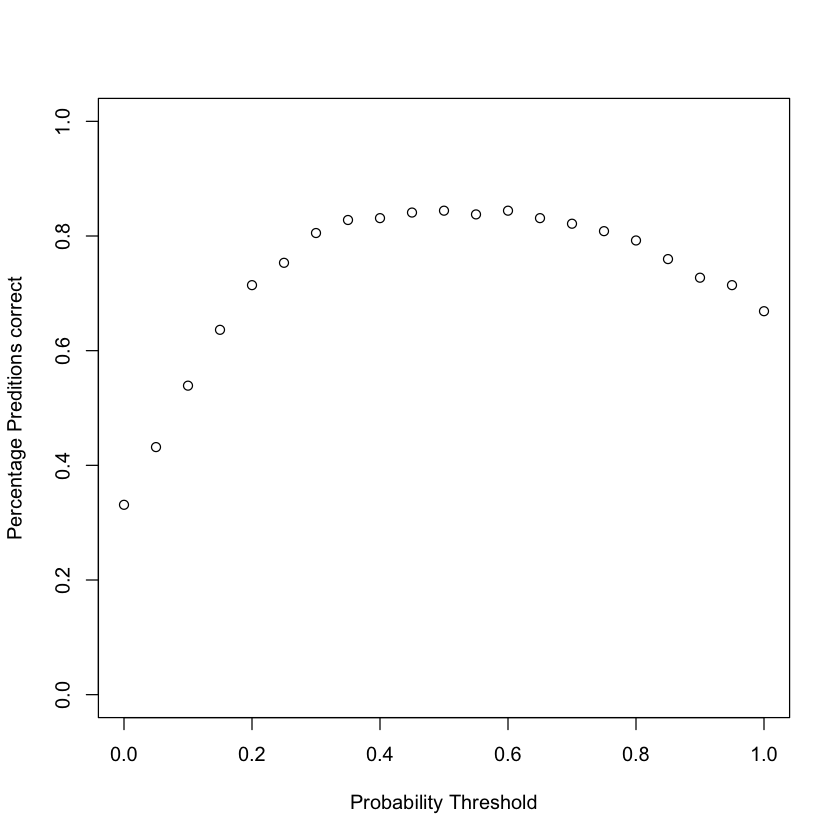

In [19]:
# Get the "predicted" presence/absence of borrellia, and see how "correct" it was?
plot(NULL,xlim=c(0,1),ylim=c(0,1), xlab=c("Probability Threshold"), ylab=c("Percentage Preditions correct"))
for ( p in seq(0,1, by = 0.05)) {
  points(x=p, y=mean((predict(mod.gambin, type = "response")>p) == tck_borrelia_adj$borrPresent))
}
# Proportion of correct predictions
mean((predict(mod.gambin, type = "response")>0.5) == tck_borrelia_adj$borrPresent)


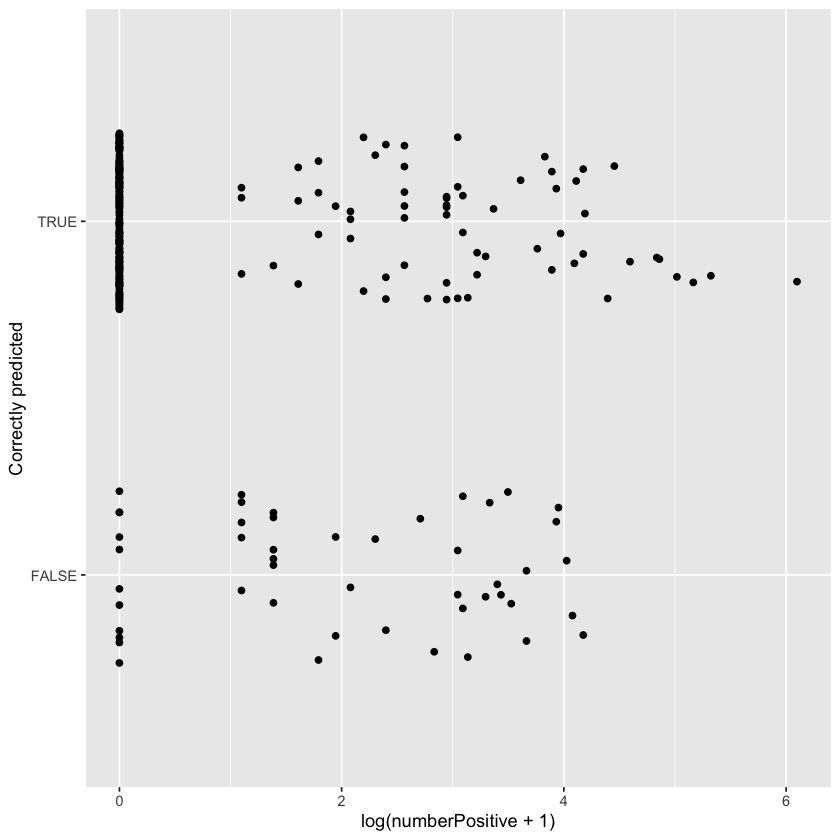

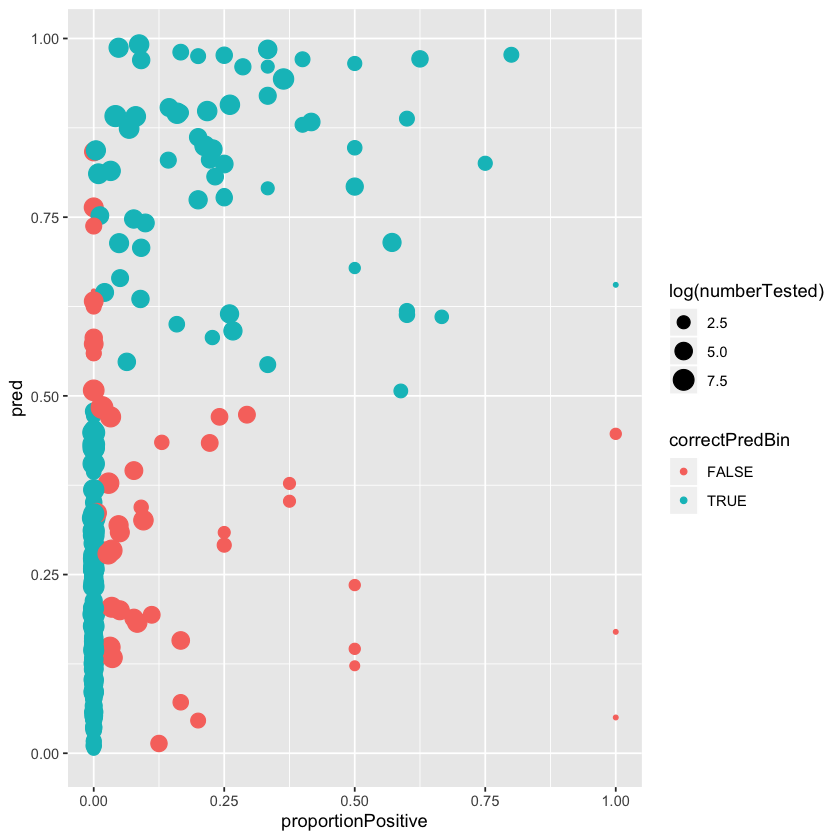

In [23]:
# Of those where they predicted presence/absence incorrectly, how "far" were they off? 
# (i.e. were there are "negative" predictions that actually had a LOT of borrellia?)
tck_borrelia_adj %>%
  mutate(pred =as.numeric(predict(mod.gambin, type="response"))
         ,correctPredBin = ((pred>0.5) == tck_borrelia_adj$borrPresent) ) %>%
  ggplot() +geom_jitter(aes(x=log(numberPositive+1), y=correctPredBin), height=0.25, width=0) + ylab("Correctly predicted")
# Ideally, you have a positive, linear correlation between proportion positive and predicted probability. "Errors" should be correlated with small sample size.
tck_borrelia_adj %>%
  mutate(pred =as.numeric(plogis(predict(mod.gambin)))
         ,correctPredBin =((pred>0.5) == tck_borrelia_adj$borrPresent) ) %>%
  ggplot() +geom_point(aes(x=proportionPositive, y=pred, col=correctPredBin, cex=log(numberTested)))


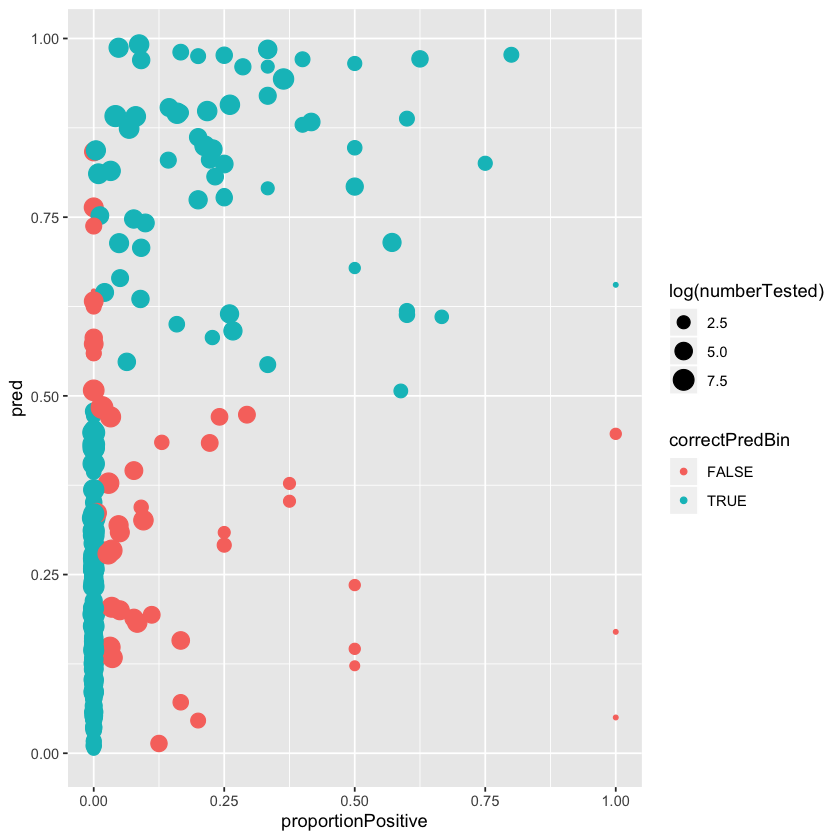

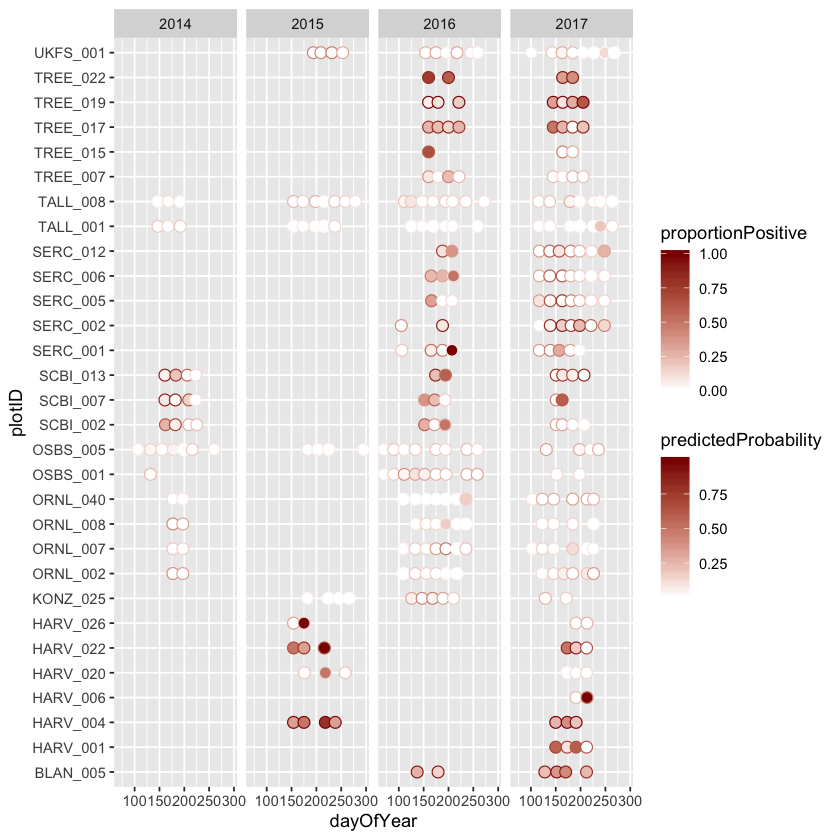

In [24]:
# What are the groups that they least accurately predicted?
tck_borrelia_adj %>%
  mutate(predictedProbability =as.numeric(plogis(predict(mod.gambin)))
         ,correctPredBin =((predictedProbability>0.5) == tck_borrelia_adj$borrPresent) 
         # , proportionPositive = ifelse(proportionPositive==0, NA, proportionPositive)
         ) %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=plotID, fill=proportionPositive, col=predictedProbability), pch=21,cex=3) +
  scale_fill_gradient(low="white", high="darkred") +
  scale_color_gradient(low="white", high="darkred") +
  facet_grid(.~year)

In [35]:
# Is there a bias for predicting negative or positive results?
tck_borrelia_adj %>%
  mutate(predictedProbability =as.numeric(plogis(predict(mod.gambin)))
         , predictedPA = (predictedProbability>0.5)
         ,correctPredBin =((predictedProbability>0.5) == tck_borrelia_adj$borrPresent) ) %>%
  select(borrPresent,predictedPA) %>% table()
paste0(c("False positive rate: ", round(11/(195+11),4)))
paste0(c("False negative rate: ", round(37/(65+37),4)))
# The false negative rate is actually a lot higher than the false positive rate. 
# This means, on average, more samples are positive then you'd expect, given the model.


           predictedPA
borrPresent FALSE TRUE
          0   195   11
          1    37   65

[1] "False positive rate: " "0.0534"

[1] "False positive rate: " "0.3627"

Now that we've fitted a binomial model to the presence/absence data, we need to fit a poisson or negative binomial model to the second part of the pseudo-hurdle model. First, we keep all positive borrelia samples. Then, for each "negative" borrelia result, we look at the predicted probability of presence in our model to determine whether it is a "binomial/hurdle" negative, or a "poisson/negbin" negative.

In [36]:
tck_borrelia_filtBin <- tck_borrelia_adj %>%
  mutate(pred=predict(mod.gambin, type="response")) %>%
  filter((borrPresent>0 | pred > 0.5))

# Double check I did the filtering correctly
tck_borrelia_filtBin %>%
  mutate(predictedPA = (pred > 0.5)) %>%
  select(borrPresent,predictedPA) %>% table()

           predictedPA
borrPresent FALSE TRUE
          0     0   11
          1    37   65

In [37]:
# Check if there is overdispersion
test_glm_filt <- glm(numberPositive ~ factor(month) + nlcdClass + plotID + year
                     , data=tck_borrelia_filtBin
                     , family="quasipoisson"
                     , offset = log(numberTested)
)
summary(test_glm_filt)



Call:
glm(formula = numberPositive ~ factor(month) + nlcdClass + plotID + 
    year, family = "quasipoisson", data = tck_borrelia_filtBin, 
    offset = log(numberTested))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-9.003  -1.895   0.000   2.118   8.483  

Coefficients: (3 not defined because of singularities)
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -4.5914     0.9105  -5.043  3.1e-06 ***
factor(month)5             0.6162     0.7178   0.858 0.393390    
factor(month)6             0.6808     0.7360   0.925 0.357962    
factor(month)7             0.5101     0.7682   0.664 0.508690    
factor(month)8             0.6103     1.0333   0.591 0.556576    
factor(month)9             1.6502     1.5206   1.085 0.281291    
nlcdClassdeciduousForest   2.1172     0.5361   3.949 0.000175 ***
nlcdClassevergreenForest   2.5122     0.7353   3.417 0.001027 ** 
nlcdClassmixedForest       1.4138     0.6127   2.308 0.023783 *  
plotIDH

In [38]:
# Try a regular poisson, and see how many zeros it finds
test_glm_filt2 <- glm(numberPositive ~ factor(month) + nlcdClass + plotID + year
                     , data=tck_borrelia_filtBin
                     , family="poisson"
                     , offset = log(numberTested)
)
mu <- predict(test_glm_filt2, type="response") # estimated mean
exp <- sum(dpois(x=0, lambda=mu)) # get probability of zero, then add those up to get total zeros expected?
round(exp)
sum(tck_borrelia_filtBin$numberPositive==0) # real number of zeros
# Yes, there appears to be overdispersion... but the zero-inflation is not nearly as much!


[1] 7

[1] 11

In [39]:
# Now try a negative binomial fit, and see how many zeros it predicts
test_glm_filt3 <- glm(proportionPositive ~ factor(month) + nlcdClass + plotID + year
                      , data=tck_borrelia_filtBin
                      , family=negative.binomial(theta = 1) 
                      , offset = log(numberTested)
)
summary(test_glm_filt3)
mu <- predict(test_glm_filt3, type="response") # estimated mean
sum(round(mu*tck_borrelia_filtBin$numberTested) == 0) # Number of zeros it estimates, given r for each sample
sum(tck_borrelia_filtBin$numberPositive==0) # real number of zeros
# The zero-inflation is significantly reduced!



Call:
glm(formula = proportionPositive ~ factor(month) + nlcdClass + 
    plotID + year, family = negative.binomial(theta = 1), data = tck_borrelia_filtBin, 
    offset = log(numberTested))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4254  -0.7928  -0.2462   0.8425   1.4728  

Coefficients: (3 not defined because of singularities)
                          Estimate Std. Error t value Pr(>|t|)   
(Intercept)              -14.94214    4.55383  -3.281  0.00157 **
factor(month)5             0.13142    3.02875   0.043  0.96550   
factor(month)6             0.06433    3.06999   0.021  0.98334   
factor(month)7             1.69979    3.09146   0.550  0.58407   
factor(month)8             1.63491    3.19162   0.512  0.60998   
factor(month)9             5.22554    3.51040   1.489  0.14079   
nlcdClassdeciduousForest   4.02886    3.13265   1.286  0.20237   
nlcdClassevergreenForest   6.22857    3.09516   2.012  0.04777 * 
nlcdClassmixedForest       4.14489    3.12875

[1] 10

[1] 11

Finally, let's run a second set of GAMs to model prevalence of borrelia in positive samples.



Method: REML   Optimizer: outer newton
full convergence after 9 iterations.
Gradient range [-0.0004754618,-3.836562e-05]
(score 896.379 & scale 1).
Hessian positive definite, eigenvalue range [0.0004753747,12.85437].
Model rank =  90 / 90 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'      edf k-index p-value
s(dayOfYear)         9.00000  3.81381    0.95    0.32
s(logNLtckDensity)   9.00000  2.73686    1.01    0.50
s(plotID)           30.00000 19.63807      NA      NA
s(dayOfYear,plotID) 30.00000 21.62326      NA      NA
s(year)              4.00000  2.57506      NA      NA
s(year,dayOfYear)    4.00000  0.00191      NA      NA


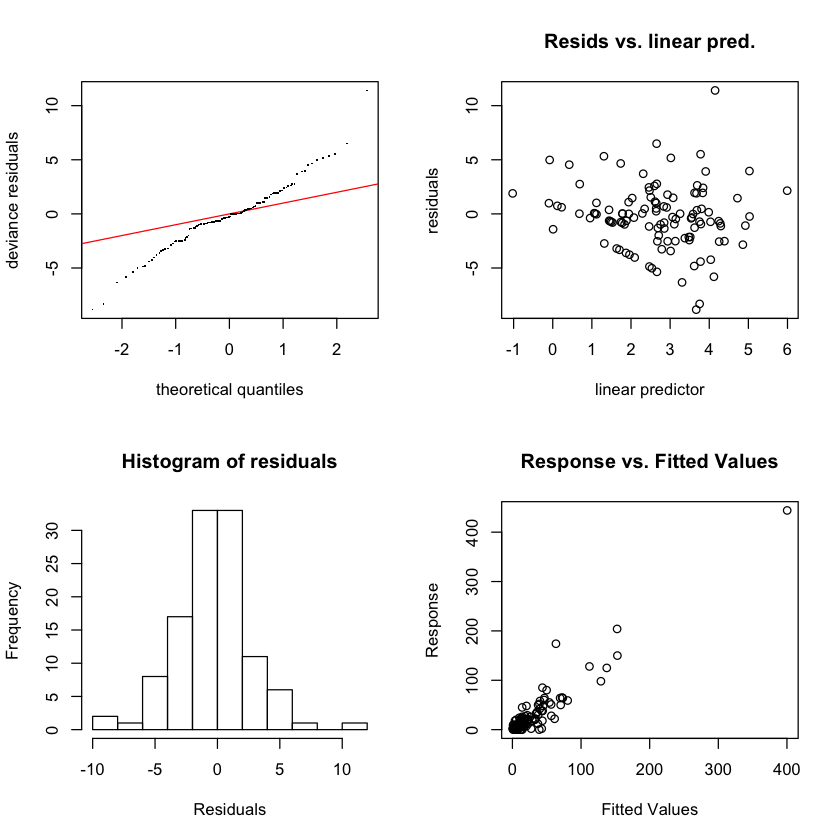

In [40]:
# make year a factor
tck_borrelia_filtBin <- tck_borrelia_filtBin %>%
  mutate(year=factor(year))

#### Finally, the second GAM model for abundance ####
mod.gam_pois <- gam(numberPositive ~ offset(log(numberTested)) +  #Offset
                  s(dayOfYear, sp=2) + s(logNLtckDensity, sp=2)  + nlcdClass +# Main effects: day of year and nymph/adult tick density
                  s(plotID, bs="re") + s(dayOfYear,plotID, bs="re") + # Random Effect of plot
                  s(year, bs="re") + s(year,dayOfYear, bs="re") # Random effect of year
                , data=tck_borrelia_filtBin
                , method="REML"
                , family="poisson")
gam.check(mod.gam_pois)


Family: poisson 
Link function: log 

Formula:
numberPositive ~ offset(log(numberTested)) + s(dayOfYear, sp = 2) + 
    s(logNLtckDensity, sp = 2) + nlcdClass + s(plotID, bs = "re") + 
    s(dayOfYear, plotID, bs = "re") + s(year, bs = "re") + s(year, 
    dayOfYear, bs = "re")

Parametric coefficients:
                         Estimate Std. Error z value Pr(>|z|)
(Intercept)               -0.8614     1.9333  -0.446    0.656
nlcdClassdeciduousForest  -1.2468     2.0162  -0.618    0.536
nlcdClassevergreenForest  -1.3977     2.6209  -0.533    0.594
nlcdClassmixedForest      -1.7245     2.6151  -0.659    0.510

Approximate significance of smooth terms:
                          edf Ref.df    Chi.sq  p-value    
s(dayOfYear)         3.813812  4.754 6.708e+01 6.02e-13 ***
s(logNLtckDensity)   2.736862  3.387 1.643e+02  < 2e-16 ***
s(plotID)           19.638074 26.000 1.021e+06 1.39e-05 ***
s(dayOfYear,plotID) 21.623256 29.000 1.227e+06 7.58e-06 ***
s(year)              2.575063  3.000 6.26

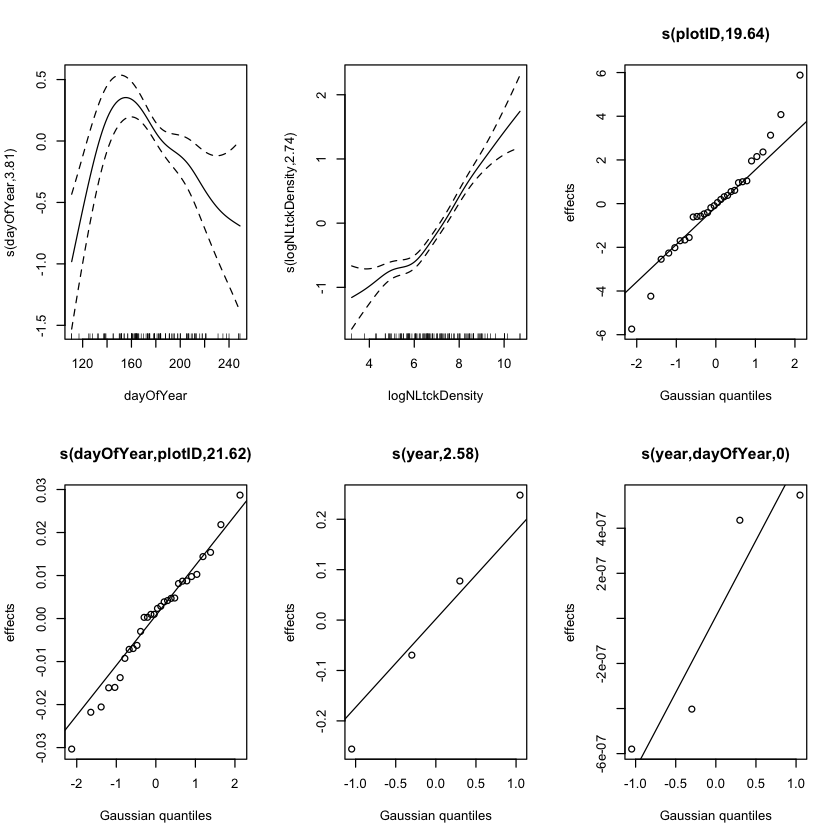

In [41]:
summary(mod.gam_pois)
plot(mod.gam_pois, pages=1, scale=0)

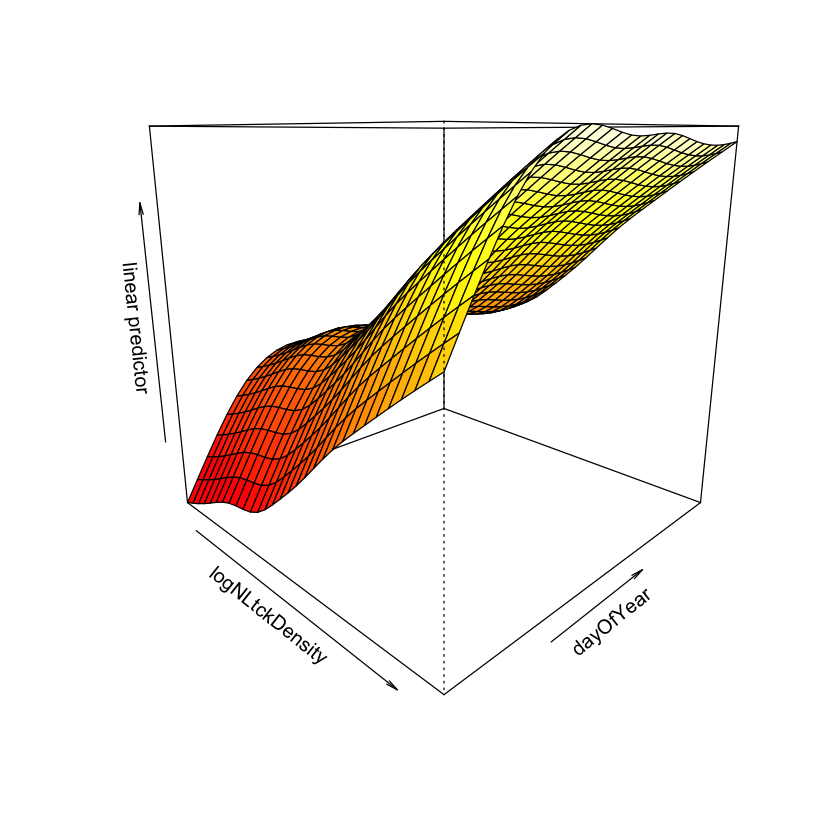

In [43]:
vis.gam(mod.gam_pois, view = c("logNLtckDensity","dayOfYear"), theta=45)


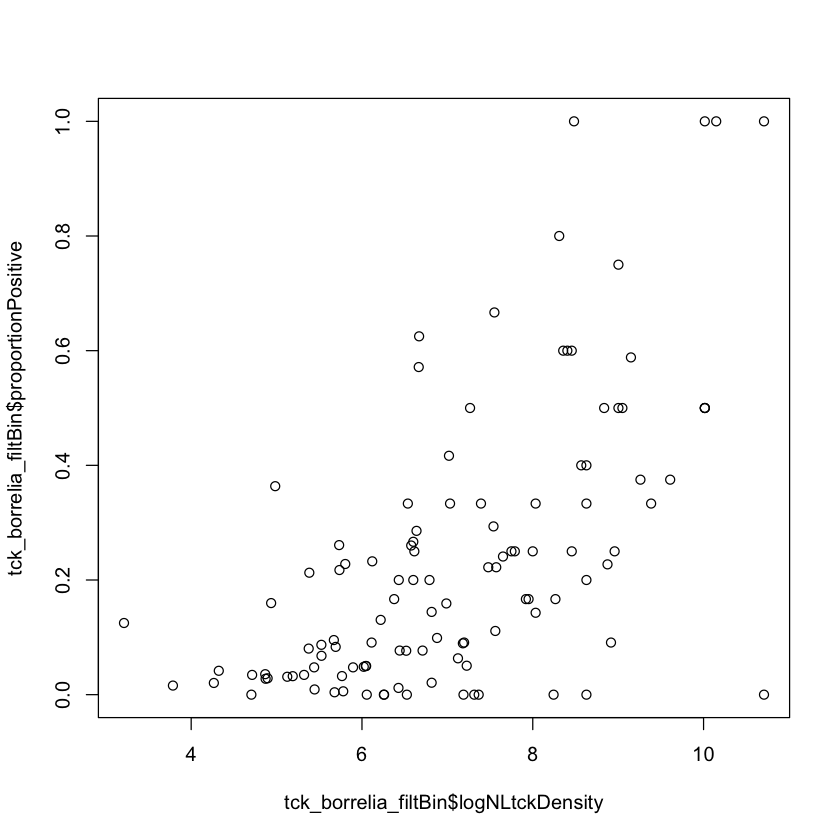

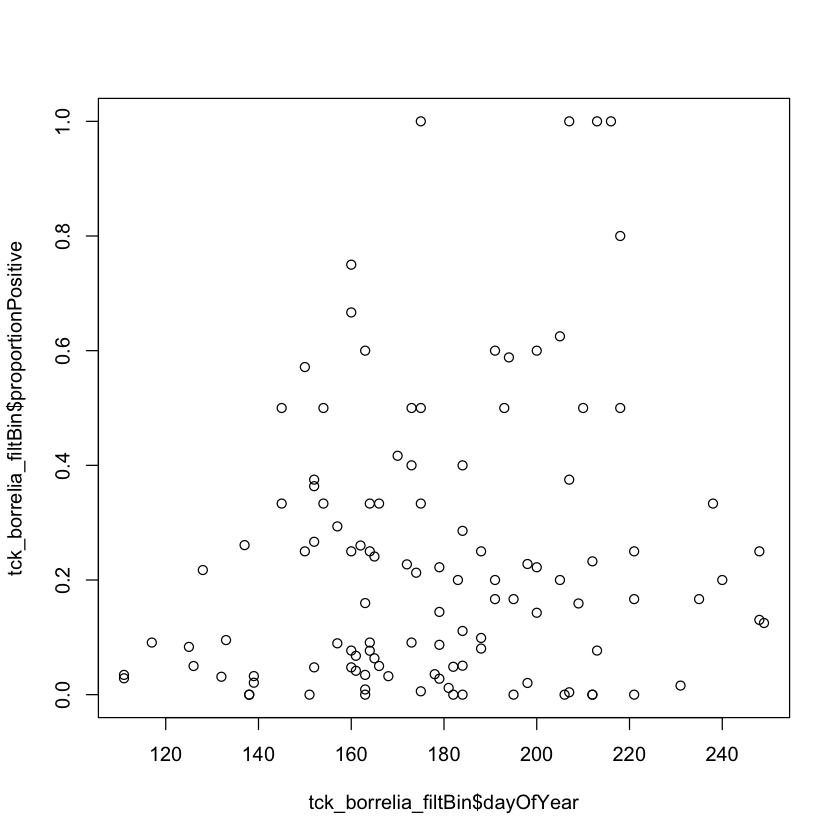

In [44]:
# sanity check to see that this relationship actually makes sense
plot(tck_borrelia_filtBin$proportionPositive ~ tck_borrelia_filtBin$logNLtckDensity)
plot(tck_borrelia_filtBin$proportionPositive ~ tck_borrelia_filtBin$dayOfYear)


Let's also try a quasi-poisson model to see if it improves fit.


Method: REML   Optimizer: outer newton
full convergence after 11 iterations.
Gradient range [-0.0001813477,0.0002672379]
(score 230.8932 & scale 12.98939).
Hessian positive definite, eigenvalue range [7.922958e-06,54.33232].
Model rank =  90 / 90 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'      edf k-index p-value  
s(dayOfYear)        9.00e+00 5.15e+00    0.90    0.12  
s(logNLtckDensity)  9.00e+00 4.02e+00    0.87    0.06 .
s(plotID)           3.00e+01 1.36e+01      NA      NA  
s(dayOfYear,plotID) 3.00e+01 7.05e-04      NA      NA  
s(year)             4.00e+00 1.74e-05      NA      NA  
s(year,dayOfYear)   4.00e+00 1.85e-05      NA      NA  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


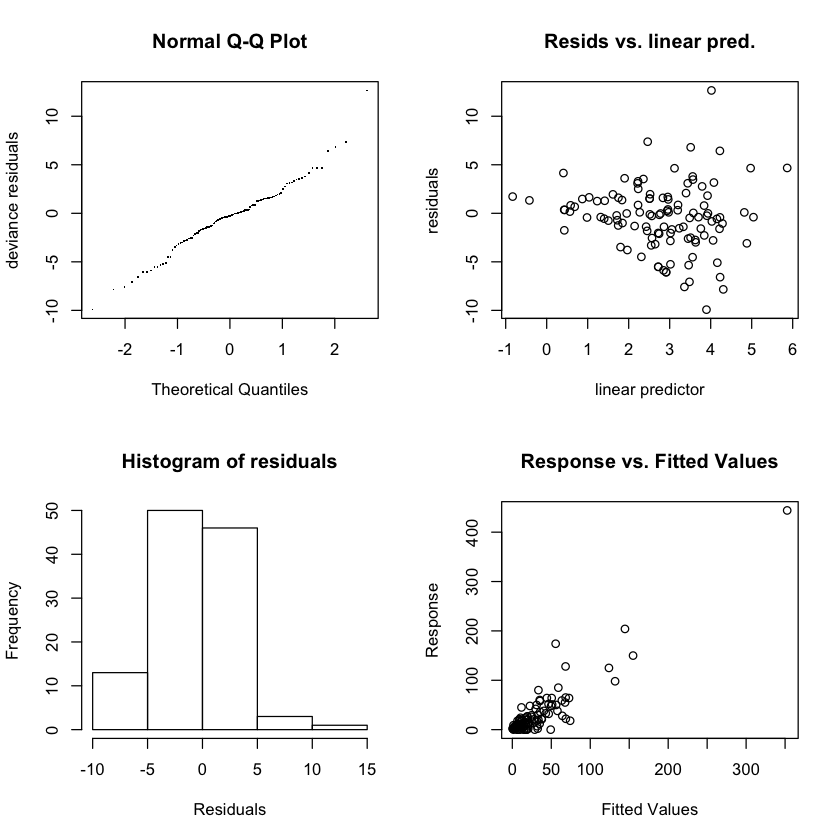

In [45]:
# Let's fit a quasipoisson to see if this improves residual distribution.
mod.gam_qpois <- gam(numberPositive ~ offset(log(numberTested)) +  #Offset
                      s(dayOfYear, sp=1) + s(logNLtckDensity, sp=1)  + nlcdClass +# Main effects: day of year and nymph/adult tick density
                      s(plotID, bs="re") + s(dayOfYear,plotID, bs="re") + # Random Effect of plot
                      s(year, bs="re") + s(year,dayOfYear, bs="re") # Random effect of year
                    , data=tck_borrelia_filtBin
                    , method="REML"
                    , family="quasipoisson")
gam.check(mod.gam_qpois)


Family: quasipoisson 
Link function: log 

Formula:
numberPositive ~ offset(log(numberTested)) + s(dayOfYear, sp = 1) + 
    s(logNLtckDensity, sp = 1) + nlcdClass + s(plotID, bs = "re") + 
    s(dayOfYear, plotID, bs = "re") + s(year, bs = "re") + s(year, 
    dayOfYear, bs = "re")

Parametric coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -2.3301     0.5005  -4.655 1.16e-05 ***
nlcdClassdeciduousForest   0.2973     0.5148   0.577    0.565    
nlcdClassevergreenForest   0.7964     0.7169   1.111    0.270    
nlcdClassmixedForest       0.8932     0.6704   1.332    0.186    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df     F  p-value    
s(dayOfYear)        5.147e+00  6.207 1.508    0.172    
s(logNLtckDensity)  4.015e+00  4.960 6.293 4.44e-05 ***
s(plotID)           1.357e+01 26.000 2.960 1.86e-10 ***
s(dayOfYear,plotID) 7.051

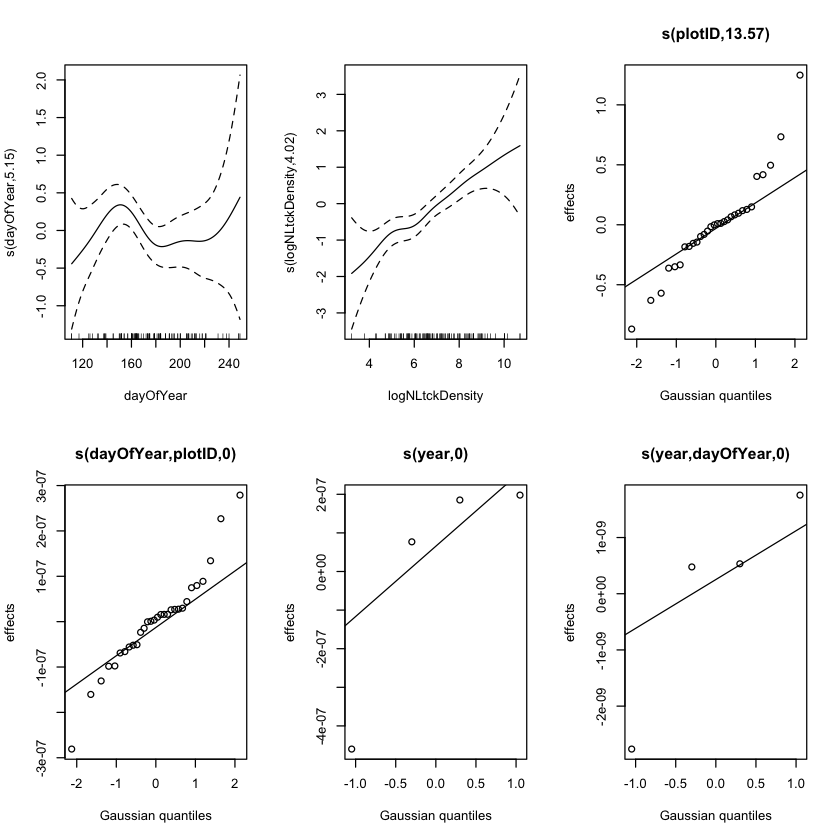

In [46]:
summary(mod.gam_qpois)
plot(mod.gam_qpois, pages=1, scale=0)

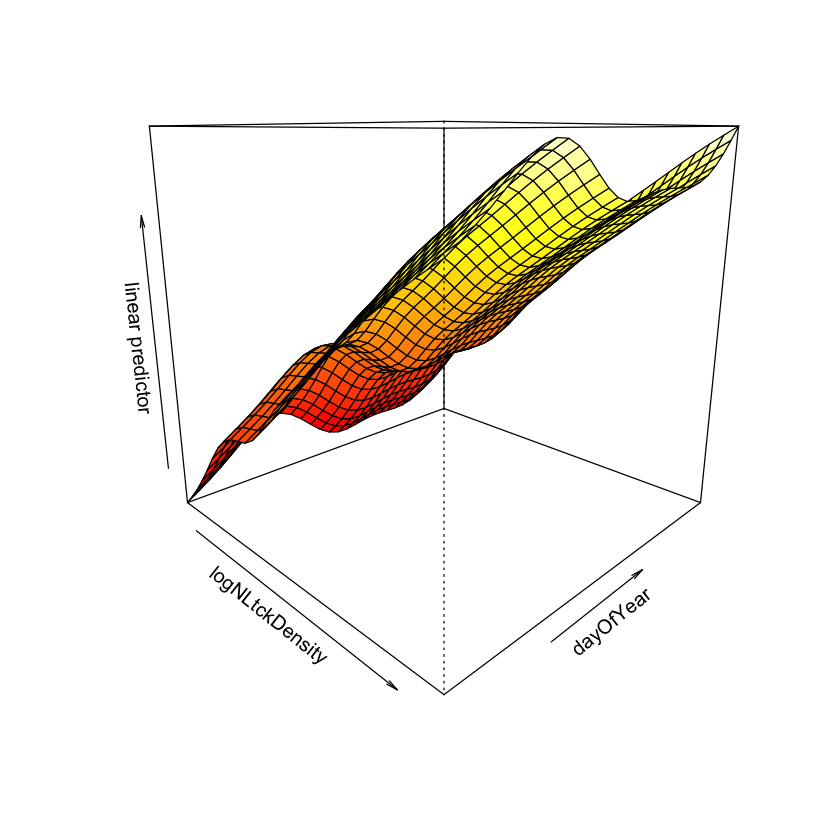

In [47]:
vis.gam(mod.gam_qpois, view = c("logNLtckDensity","dayOfYear"), theta=45)


In my opinion, I think the regular poisson looks better. Finally, let's try a negative binomial model.


Method: REML   Optimizer: outer newton
full convergence after 10 iterations.
Gradient range [-9.166316e-05,4.737323e-07]
(score 459.1966 & scale 1).
Hessian positive definite, eigenvalue range [7.116824e-06,42.59625].
Model rank =  90 / 90 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'      edf k-index p-value  
s(dayOfYear)        9.00e+00 2.13e+00    0.82   0.090 .
s(logNLtckDensity)  9.00e+00 1.00e+00    0.80   0.065 .
s(plotID)           3.00e+01 5.49e+00      NA      NA  
s(dayOfYear,plotID) 3.00e+01 6.96e-04      NA      NA  
s(year)             4.00e+00 2.03e-05      NA      NA  
s(year,dayOfYear)   4.00e+00 1.97e-05      NA      NA  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


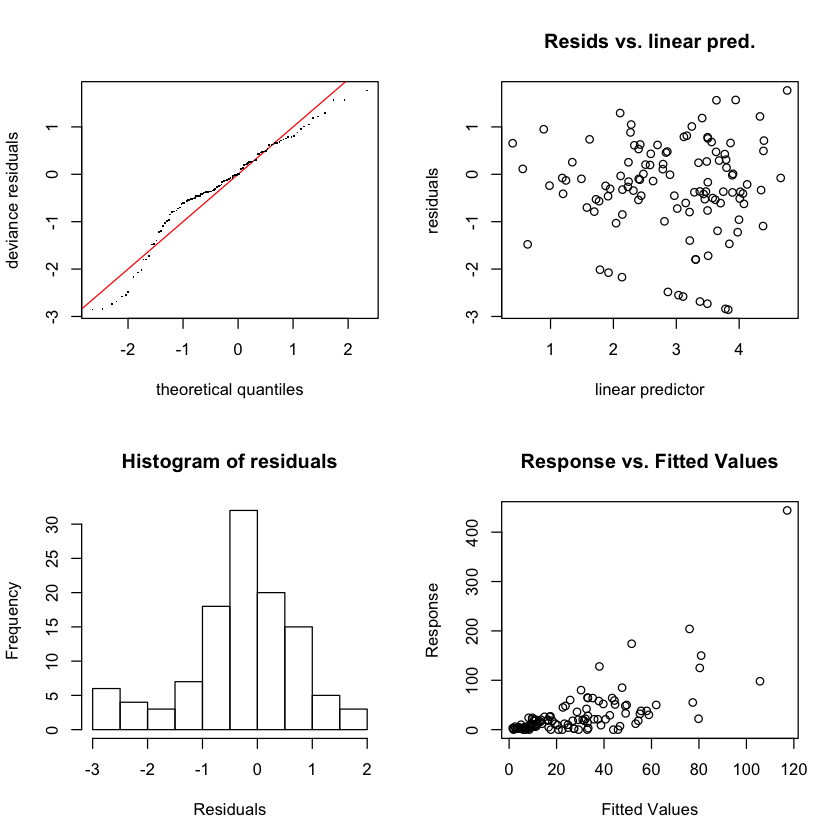

In [57]:
## Last option: a negative binomial.
mod.gam_nb <- gam(numberPositive ~ 
                       s(dayOfYear) + s(logNLtckDensity)  + nlcdClass +# Main effects: day of year and nymph/adult tick density
                       s(plotID, bs="re") + s(dayOfYear,plotID, bs="re") + # Random Effect of plot
                       s(year, bs="re") + s(year,dayOfYear, bs="re") # Random effect of year
                     , data=tck_borrelia_filtBin
                     , method="REML"
                     , family=nb)
gam.check(mod.gam_nb)


Family: Negative Binomial(1.081) 
Link function: log 

Formula:
numberPositive ~ s(dayOfYear) + s(logNLtckDensity) + nlcdClass + 
    s(plotID, bs = "re") + s(dayOfYear, plotID, bs = "re") + 
    s(year, bs = "re") + s(year, dayOfYear, bs = "re")

Parametric coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)                2.4905     0.4454   5.591 2.26e-08 ***
nlcdClassdeciduousForest   0.3569     0.4600   0.776    0.438    
nlcdClassevergreenForest   0.6782     0.6070   1.117    0.264    
nlcdClassmixedForest       0.7426     0.5555   1.337    0.181    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df Chi.sq  p-value    
s(dayOfYear)        2.132e+00  2.683 16.325 0.000961 ***
s(logNLtckDensity)  1.000e+00  1.000 50.137 1.44e-12 ***
s(plotID)           5.495e+00 26.000  7.570 0.114704    
s(dayOfYear,plotID) 6.965e-04 29.000  0.001 0.765063    
s

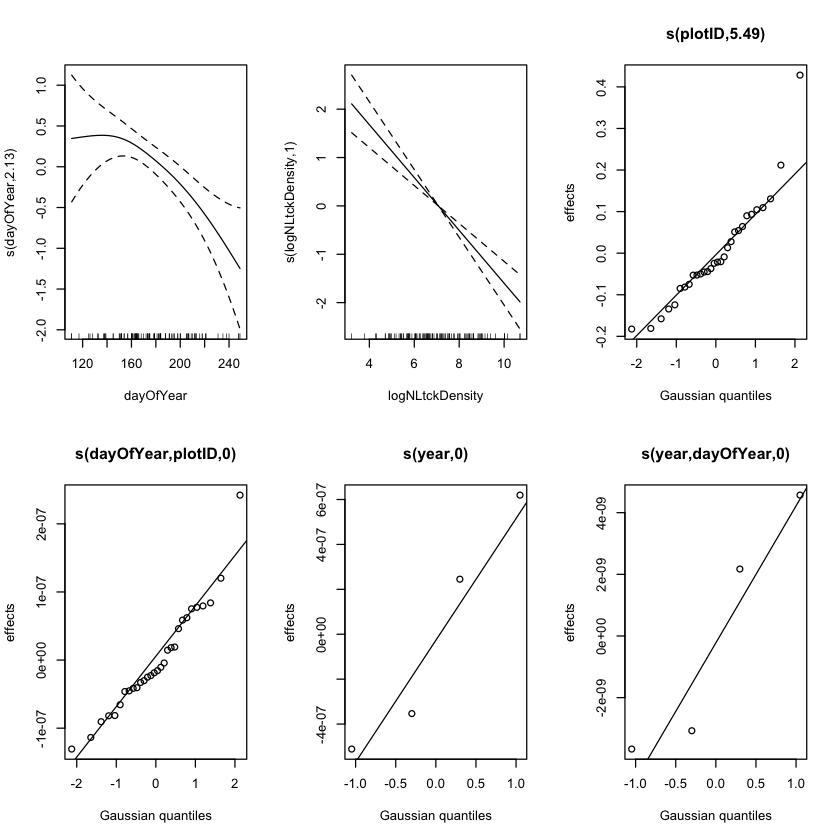

In [58]:
summary(mod.gam_nb)
plot(mod.gam_nb, pages=1, scale=0)

Honestly, I think the poisson distribution fits the data better than the negative binomial.

## Fitting GAMs to completely non-zero counts

One last thing to try with GAMs before we move onto brms is to see what the fit looks like if we simply remove all zeros.


Method: REML   Optimizer: outer newton
full convergence after 10 iterations.
Gradient range [-0.0003277766,0.0001255724]
(score 724.2823 & scale 1).
Hessian positive definite, eigenvalue range [0.0003277506,11.5793].
Model rank =  90 / 90 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'      edf k-index p-value
s(dayOfYear)         9.00000  4.02574    1.09    0.83
s(logNLtckDensity)   9.00000  3.42637    1.03    0.59
s(plotID)           30.00000 17.55513      NA      NA
s(dayOfYear,plotID) 30.00000 18.14525      NA      NA
s(year)              4.00000  2.75692      NA      NA
s(year,dayOfYear)    4.00000  0.00116      NA      NA


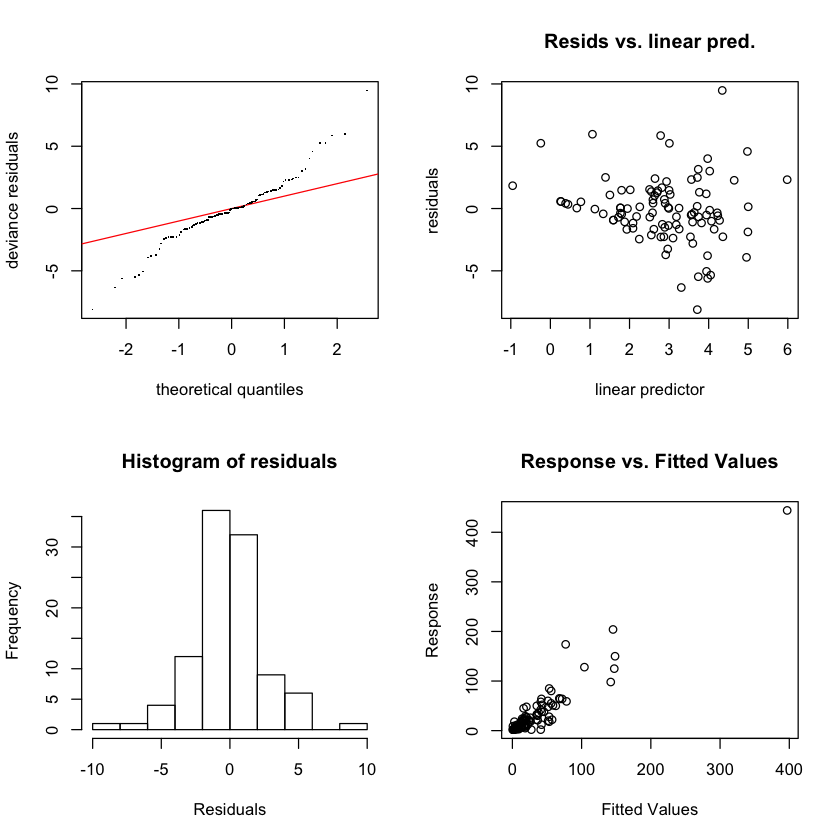

In [60]:
#### GAM on non-zero counts ####
# Filter to only non-zeros
tck_borrelia_nozeros <- tck_borrelia_adj %>%
  filter(numberPositive>0) %>%
  mutate(year=factor(year))

mod.gam_pois_nozeros <- gam(numberPositive ~ offset(log(numberTested)) +  #Offset
                      s(dayOfYear, sp=2) + s(logNLtckDensity, sp=1)  + nlcdClass +# Main effects: day of year and nymph/adult tick density
                      s(plotID, bs="re") + s(dayOfYear,plotID, bs="re") + # Random Effect of plot
                      s(year, bs="re") + s(year,dayOfYear, bs="re") # Random effect of year
                    , data=tck_borrelia_nozeros
                    , method="REML"
                    , family="poisson")
gam.check(mod.gam_pois_nozeros)


Family: poisson 
Link function: log 

Formula:
numberPositive ~ offset(log(numberTested)) + s(dayOfYear, sp = 2) + 
    s(logNLtckDensity, sp = 1) + nlcdClass + s(plotID, bs = "re") + 
    s(dayOfYear, plotID, bs = "re") + s(year, bs = "re") + s(year, 
    dayOfYear, bs = "re")

Parametric coefficients:
                         Estimate Std. Error z value Pr(>|z|)
(Intercept)               -1.6970     1.0761  -1.577    0.115
nlcdClassdeciduousForest  -0.1902     1.1217  -0.170    0.865
nlcdClassevergreenForest  -0.2369     1.4693  -0.161    0.872
nlcdClassmixedForest      -0.6627     1.4479  -0.458    0.647

Approximate significance of smooth terms:
                          edf Ref.df    Chi.sq  p-value    
s(dayOfYear)         4.025736  4.905 6.491e+01 2.30e-12 ***
s(logNLtckDensity)   3.426370  4.193 1.480e+02  < 2e-16 ***
s(plotID)           17.555133 26.000 1.914e+05 3.58e-05 ***
s(dayOfYear,plotID) 18.145247 29.000 1.522e+05 0.000718 ***
s(year)              2.756924  3.000 5.02

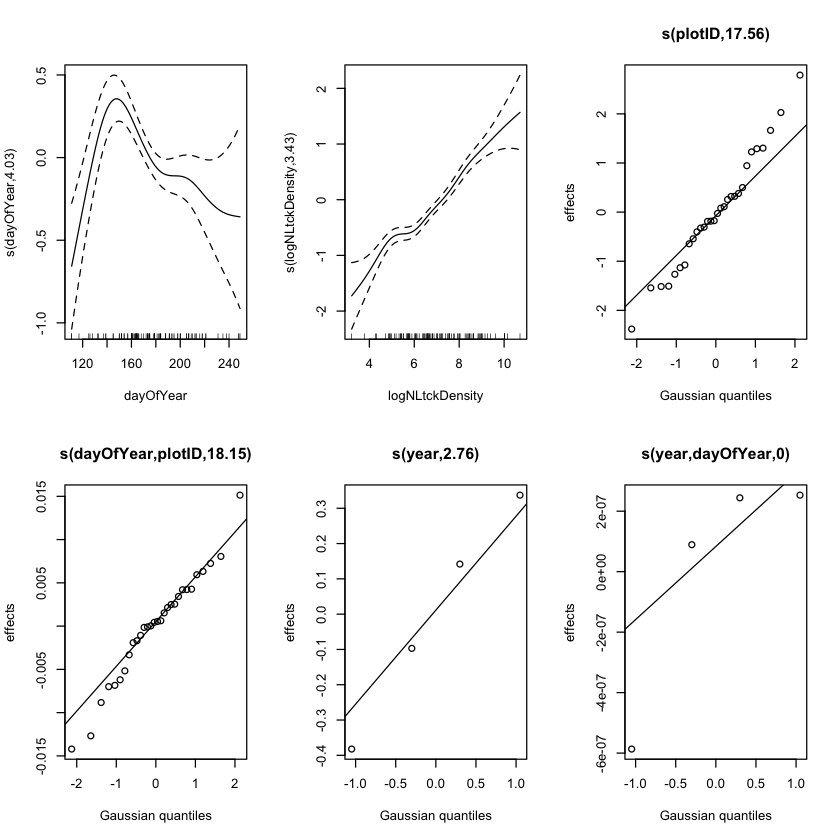

In [61]:
summary(mod.gam_pois_nozeros)
plot(mod.gam_pois_nozeros, pages=1, scale=0)

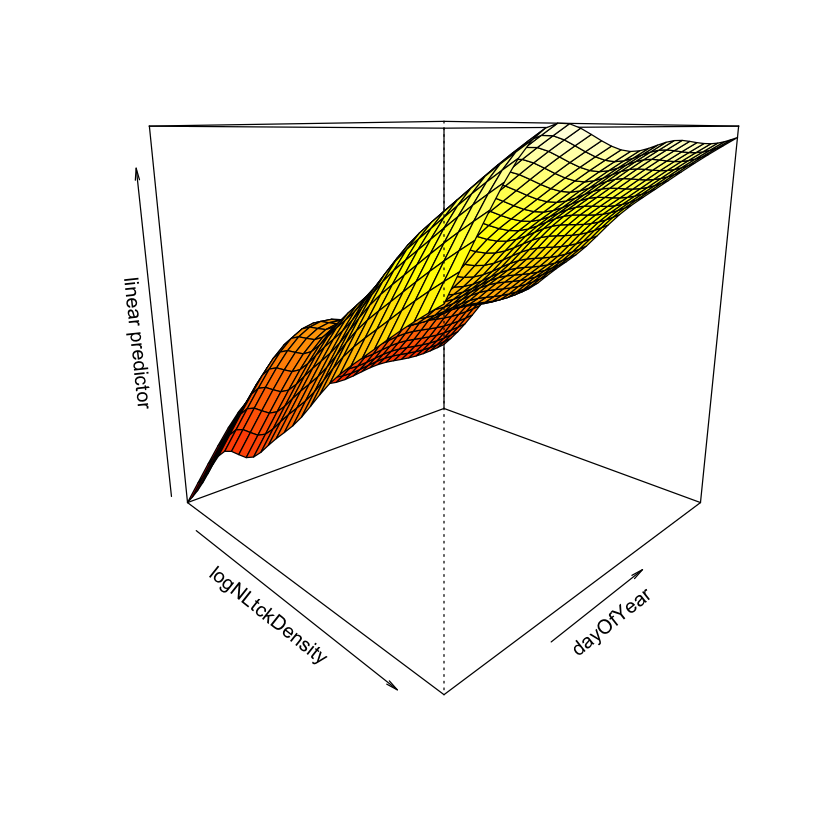

In [62]:
vis.gam(mod.gam_pois_nozeros, view = c("logNLtckDensity","dayOfYear"), theta=45)



Method: REML   Optimizer: outer newton
full convergence after 11 iterations.
Gradient range [-0.0001670388,0.0002913383]
(score 198.3134 & scale 11.0678).
Hessian positive definite, eigenvalue range [1.839431e-05,48.84592].
Model rank =  90 / 90 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'      edf k-index p-value
s(dayOfYear)        9.00e+00 4.49e+00    1.04    0.60
s(logNLtckDensity)  9.00e+00 4.07e+00    0.95    0.28
s(plotID)           3.00e+01 1.28e+01      NA      NA
s(dayOfYear,plotID) 3.00e+01 6.28e-04      NA      NA
s(year)             4.00e+00 8.18e-05      NA      NA
s(year,dayOfYear)   4.00e+00 8.83e-05      NA      NA


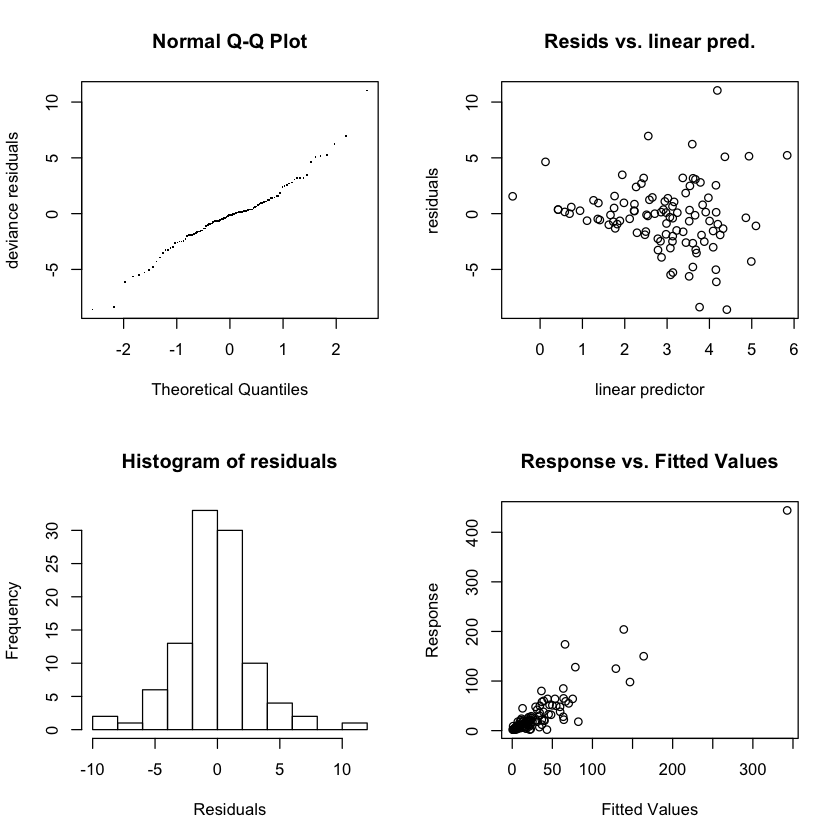

In [63]:
mod.gam_qpois_nozeros <- gam(numberPositive ~ offset(log(numberTested)) +  #Offset
                       s(dayOfYear, sp=2) + s(logNLtckDensity, sp=1)  + nlcdClass +# Main effects: day of year and nymph/adult tick density
                       s(plotID, bs="re") + s(dayOfYear,plotID, bs="re") + # Random Effect of plot
                       s(year, bs="re") + s(year,dayOfYear, bs="re") # Random effect of year
                     , data=tck_borrelia_nozeros
                     , method="REML"
                     , family="quasipoisson")
gam.check(mod.gam_qpois_nozeros)


Family: quasipoisson 
Link function: log 

Formula:
numberPositive ~ offset(log(numberTested)) + s(dayOfYear, sp = 2) + 
    s(logNLtckDensity, sp = 1) + nlcdClass + s(plotID, bs = "re") + 
    s(dayOfYear, plotID, bs = "re") + s(year, bs = "re") + s(year, 
    dayOfYear, bs = "re")

Parametric coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -2.3580     0.4413  -5.343 9.07e-07 ***
nlcdClassdeciduousForest   0.4956     0.4539   1.092    0.278    
nlcdClassevergreenForest   0.8495     0.6345   1.339    0.185    
nlcdClassmixedForest       0.9160     0.5894   1.554    0.124    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df     F  p-value    
s(dayOfYear)        4.488e+00  5.471 2.135   0.0743 .  
s(logNLtckDensity)  4.072e+00  5.009 7.829 3.94e-06 ***
s(plotID)           1.279e+01 26.000 2.502 1.01e-08 ***
s(dayOfYear,plotID) 6.283

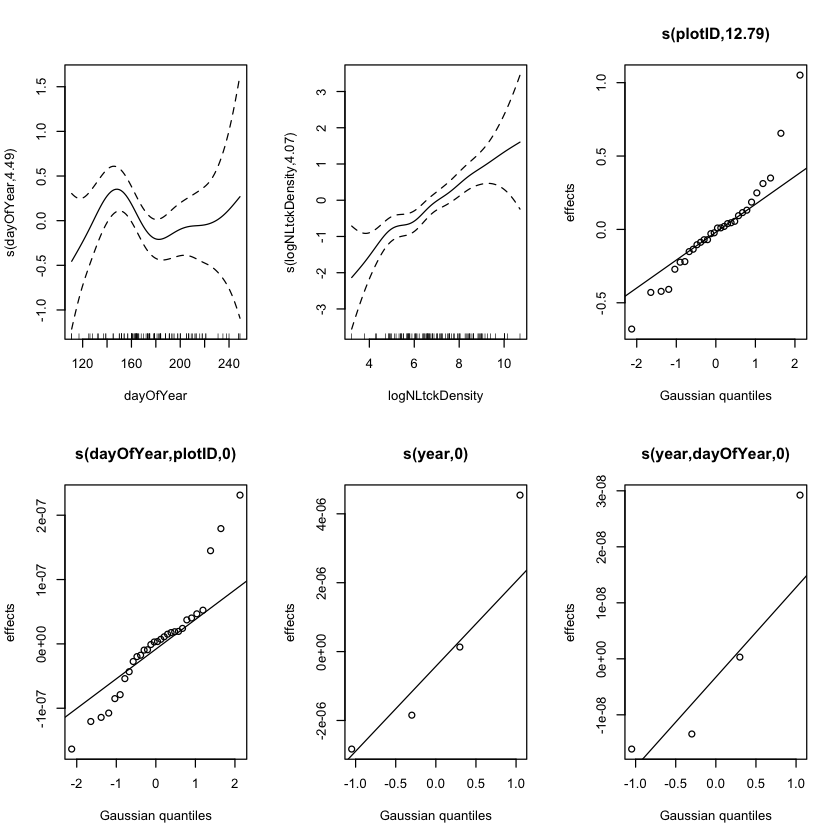

In [64]:
summary(mod.gam_qpois_nozeros)
plot(mod.gam_qpois_nozeros, pages=1, scale=0)

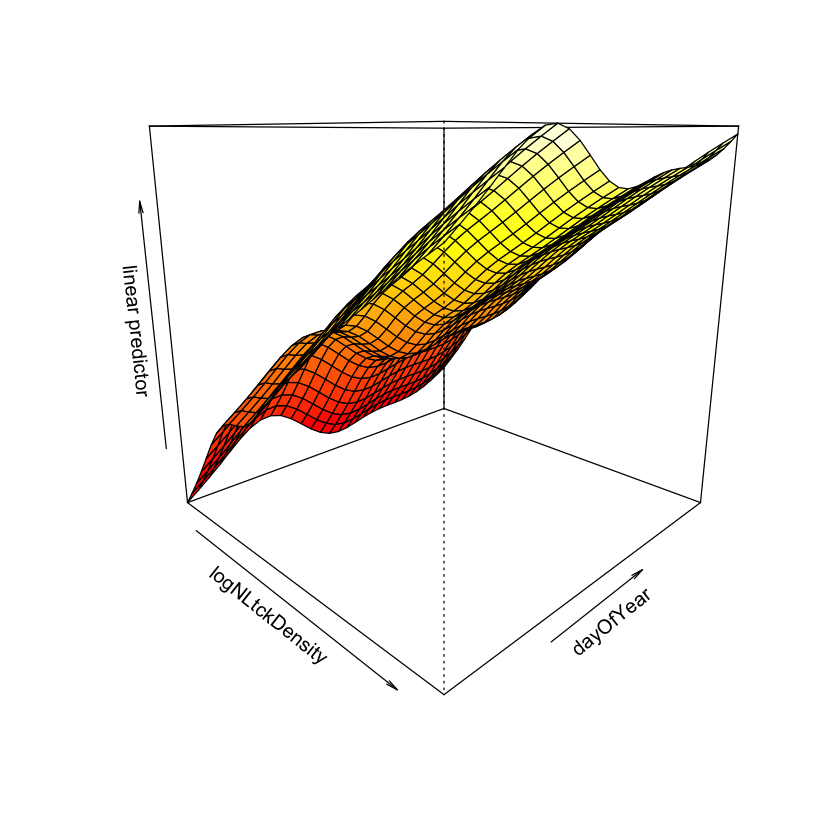

In [65]:
vis.gam(mod.gam_qpois_nozeros, view = c("logNLtckDensity","dayOfYear"), theta=45)


## GAMs in a bayesian framework

Now that we've tried a few GAMs, let's transfer this to a bayesian framework. First, we model the hurdle component

In [67]:
# Hurdle component
if (FALSE ) {
  brm_bin <- brm(bf(borrPresent ~ s(dayOfYear) + nlcdClass + s(plotID, bs="re") + s(dayOfYear,plotID, bs="re") + s(logNLtckDensity) + offset(log(numberTested)))
                 # , offset=log(numberTested) # I include the offset in the formula instead, so that it is included in predictions. Including it here does NOT incorporate numberTested in predictiosn.
                 , data=tck_borrelia_adj
                 , seed=92834
                 , family=bernoulli
                 , control=list(adapt_delta=0.999))
  save(brm_bin, file="brm_bin.RData")
} else {
  load("brm_bin.RData")
}

summary(brm_bin)

 Family: bernoulli 
  Links: mu = logit 
Formula: borrPresent ~ s(dayOfYear) + nlcdClass + s(plotID, bs = "re") + s(dayOfYear, plotID, bs = "re") + s(logNLtckDensity) + offset(log(numberTested)) 
   Data: tck_borrelia_adj (Number of observations: 308) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Smooth Terms: 
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sds(sdayOfYear_1)           2.68      2.57     0.09     9.42 1.00     1665
sds(splotID_1)              1.47      0.68     0.14     2.81 1.01      425
sds(sdayOfYearplotID_1)     2.04      1.09     0.14     4.20 1.01      469
sds(slogNLtckDensity_1)     2.01      2.11     0.04     7.59 1.00     1862
                        Tail_ESS
sds(sdayOfYear_1)           2084
sds(splotID_1)               727
sds(sdayOfYearplotID_1)     1058
sds(slogNLtckDensity_1)     2206

Population-Level Effects: 
                         Estimate Est.Error l-95% CI u

Using 10 posterior samples for ppc type 'ecdf_overlay' by default.


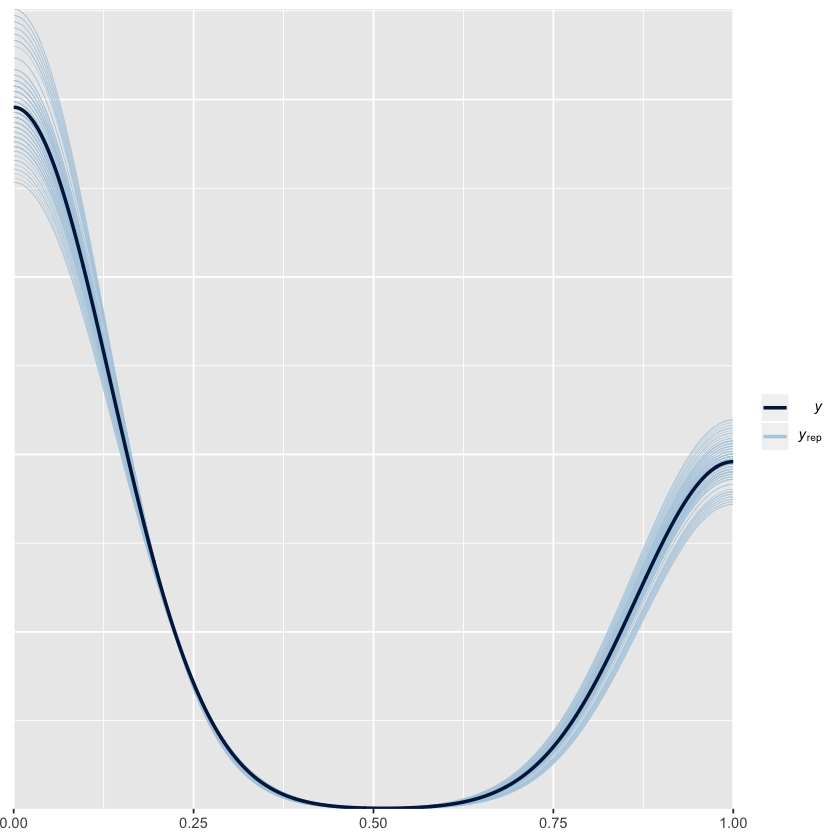

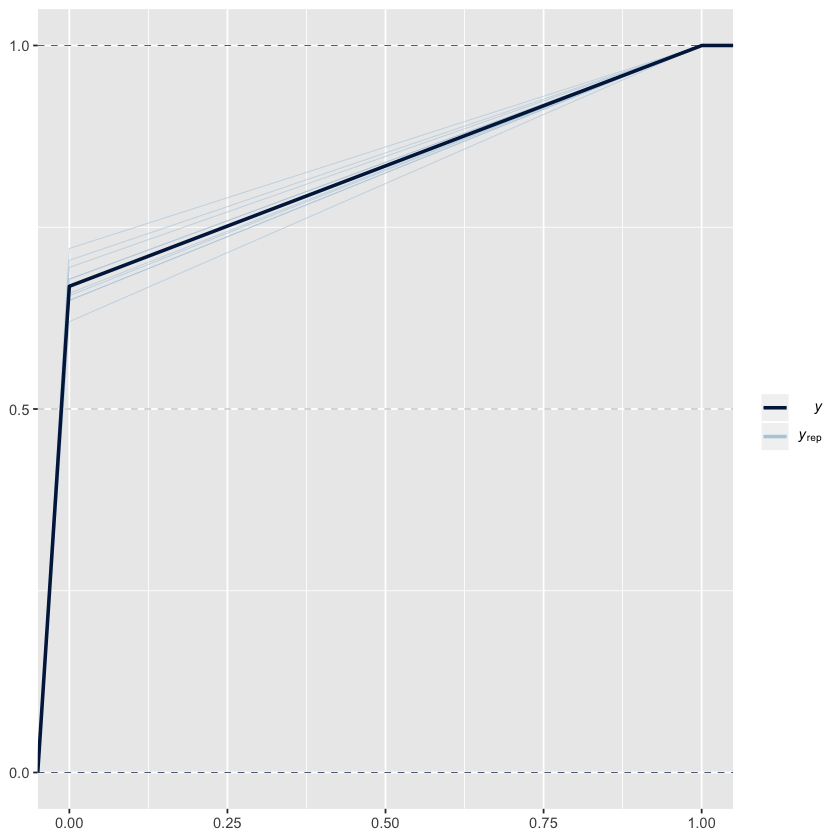

In [68]:
stanfit_bin <- rstan::extract(brm_bin$fit)
pp_check(brm_bin, nsamples = 100)
pp_check(brm_bin, type = "ecdf_overlay")


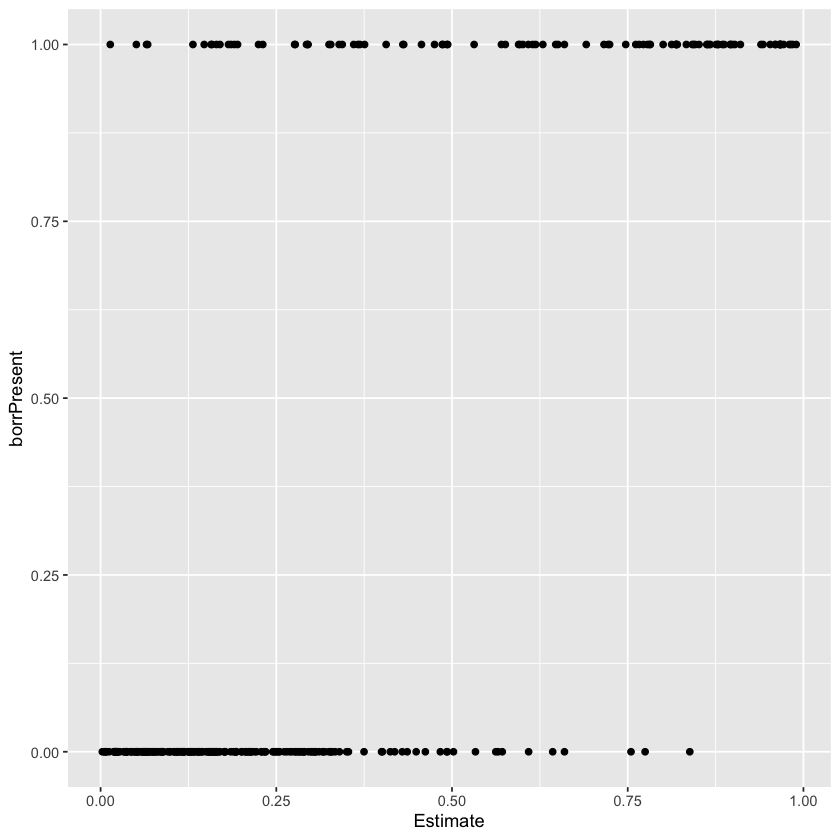

In [69]:
# Look at how estimated probability maps to actual data for borrelia
fitted(brm_bin) %>%
  cbind(brm_bin$data) %>%
  ggplot() +geom_point(aes(x=Estimate, y=borrPresent))


In [70]:
# Inspect error rate (false positive and false negative)
predict(brm_bin) %>%
  cbind(brm_bin$data) %>%
  mutate(Pred = ifelse(Estimate>0.5, 1, 0)) %>%
  select(borrPresent, Pred) %>% table()
11/(11+195) # false positive rate
38/(38+64) # false negative rate

           Pred
borrPresent   0   1
          0 196  10
          1  38  64

[1] 0.05339806

[1] 0.372549

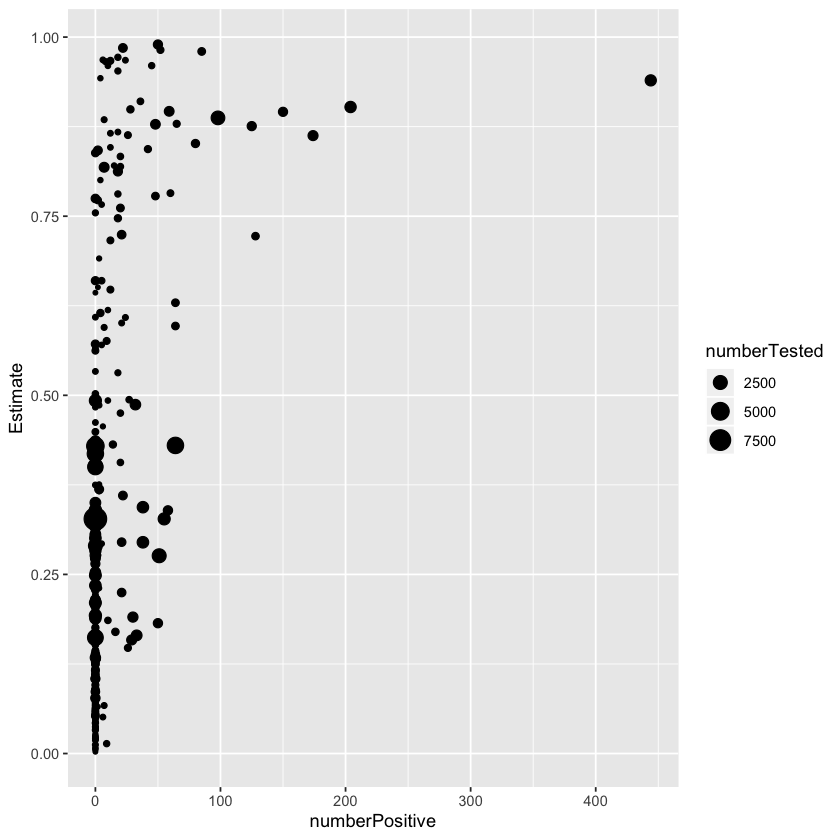

In [71]:

# See if there is correlation between probability and how many positives there actually were
fitted(brm_bin) %>%
  cbind(tck_borrelia_adj[,c("proportionPositive","numberPositive", "numberTested")]) %>%
  ggplot() + geom_point(aes(x=numberPositive, y=Estimate, cex=numberTested)) 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


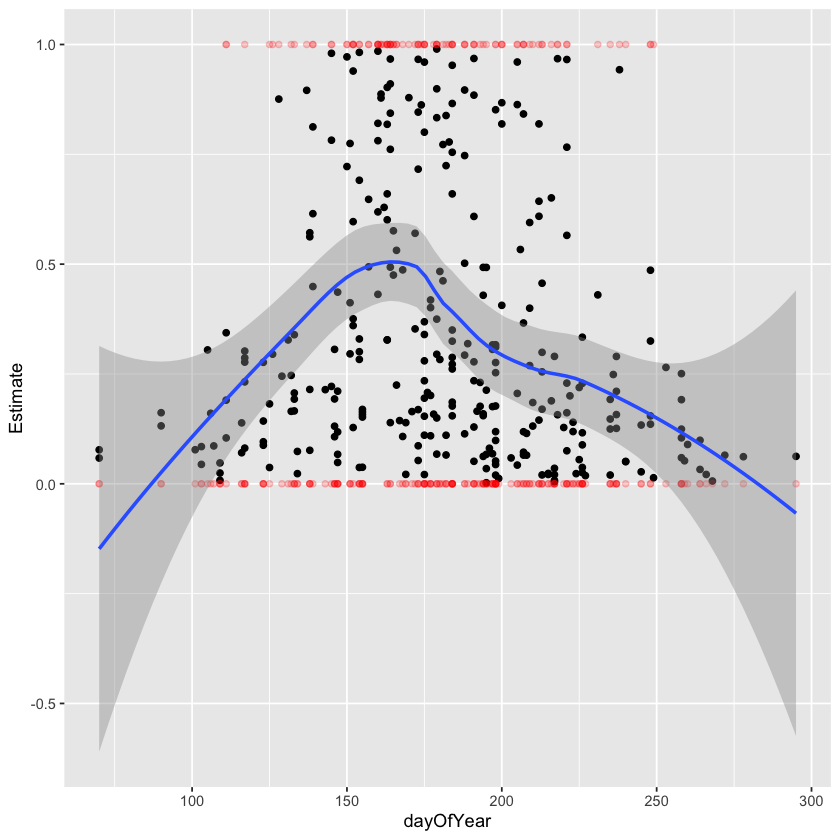

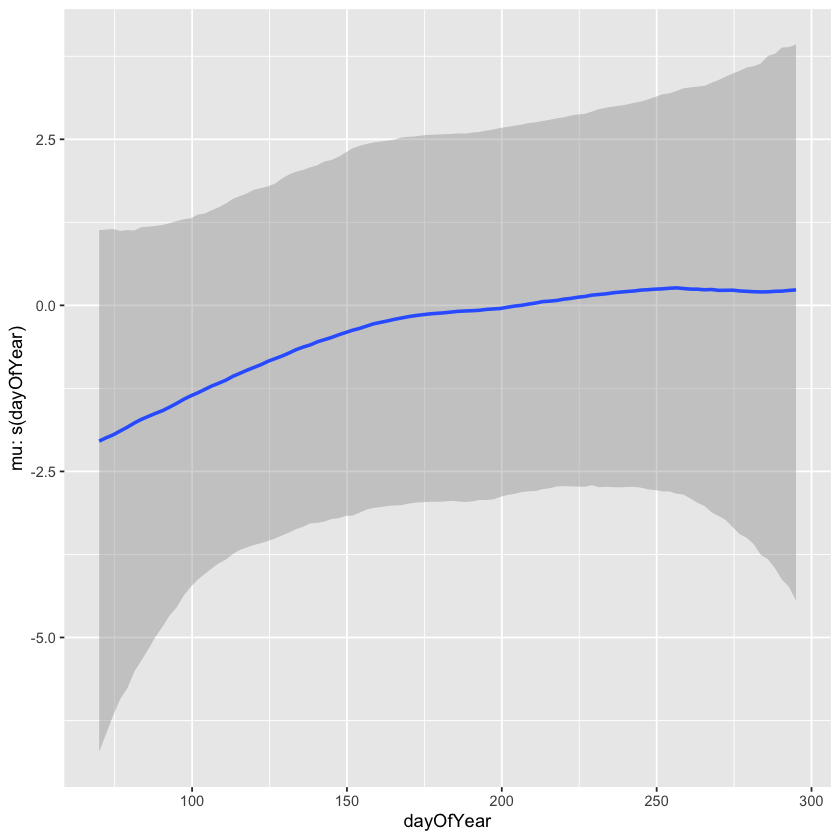

In [72]:
## Look at effect of various predictors
# Effect of day of year
fitted(brm_bin) %>%
  cbind(brm_bin$data) %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=Estimate)) + geom_point(aes(x=dayOfYear, y=borrPresent), col="red",alpha=0.2) + geom_smooth(aes(x=dayOfYear, y=borrPresent))
conditional_smooths(brm_bin, smooths="s(dayOfYear)")


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


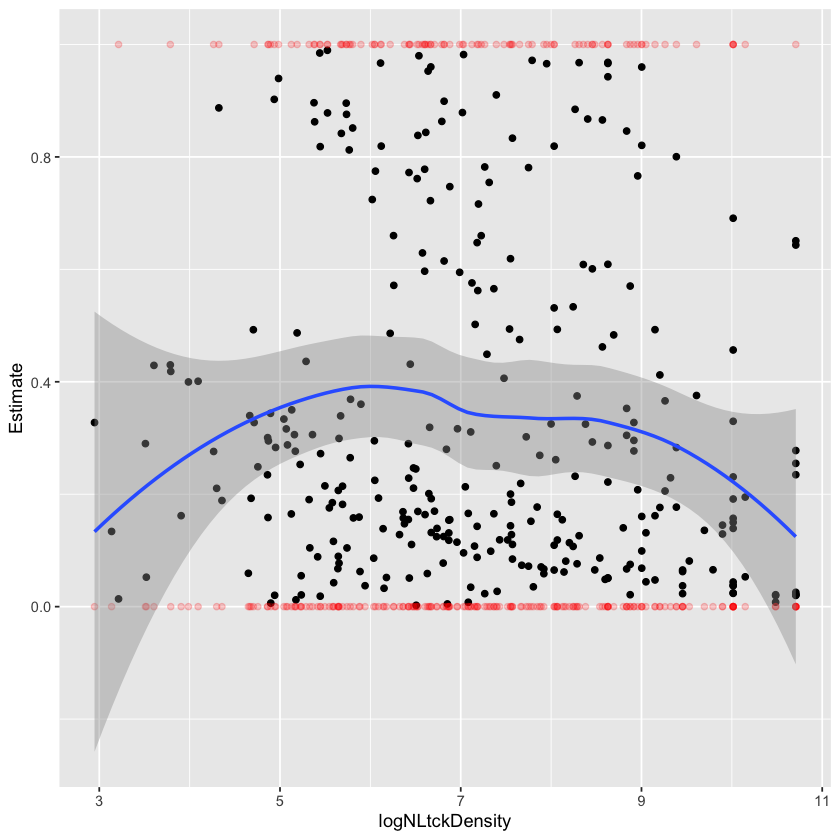

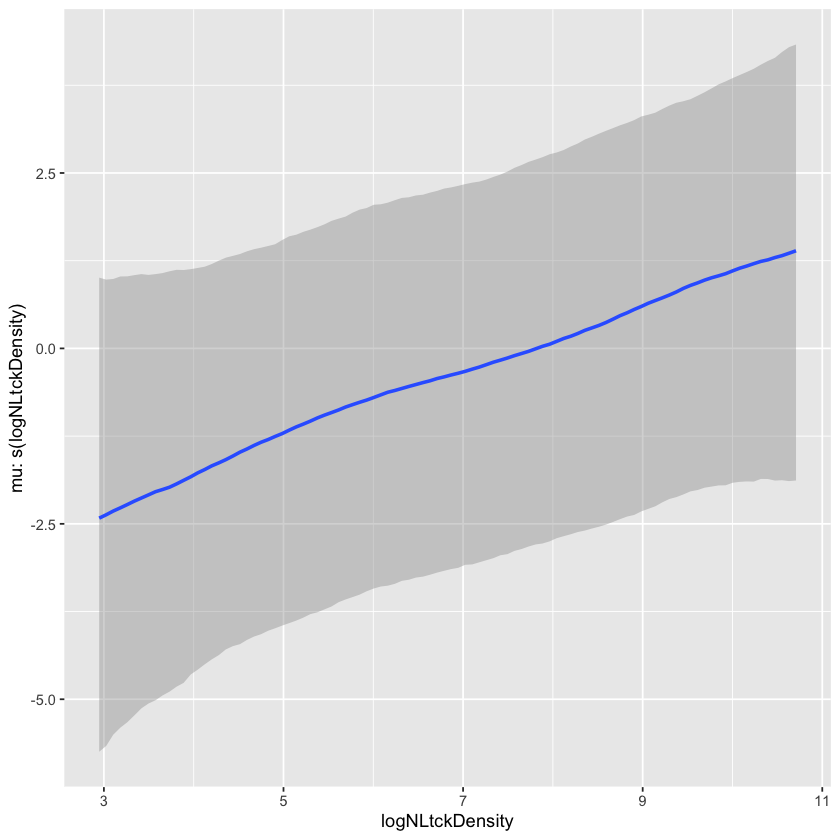

In [73]:
# Effect of tck density
fitted(brm_bin) %>%
  cbind(brm_bin$data) %>%
  ggplot() + geom_point(aes(x=logNLtckDensity, y=Estimate)) + geom_point(aes(x=logNLtckDensity, y=borrPresent), col="red",alpha=0.2) + geom_smooth(aes(x=logNLtckDensity, y=borrPresent)) 
conditional_smooths(brm_bin, smooths="s(logNLtckDensity)")


In [74]:
# Since each sample is IID, we can include all positive results in poisson component of model, and use fitted probabilities to determine
# whether each zero is a "binomial" zero or a "poisson" zero.

tck_borrelia_filtbin_brm <- tck_borrelia_adj %>%
  cbind(predict(brm_bin)) %>%
  filter(borrPresent>0 | Estimate>0.5)

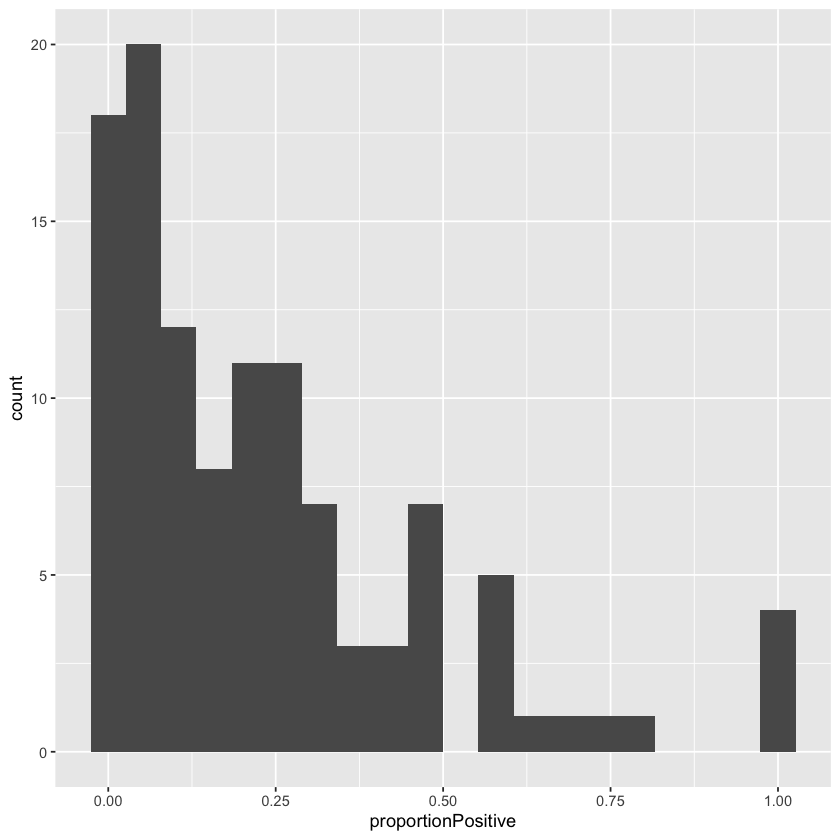

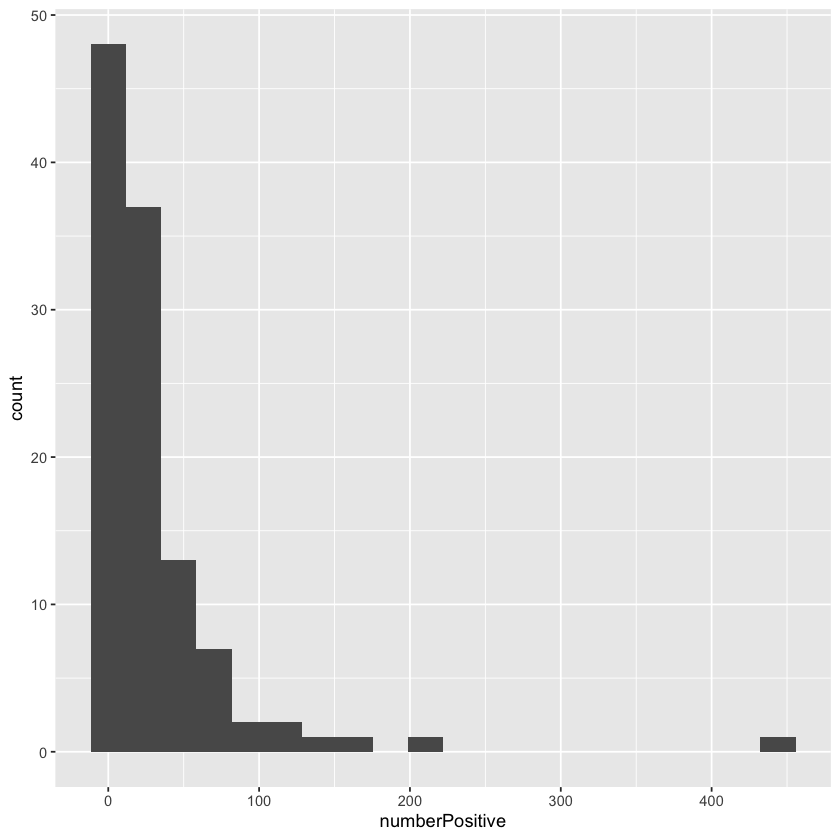

In [75]:
## Now try to fit a poisson distribution?
tck_borrelia_filtbin_brm %>%
  ggplot() + geom_histogram(aes(x=proportionPositive), bins=20)
tck_borrelia_filtbin_brm %>%
  ggplot() + geom_histogram(aes(x=numberPositive), bins=20)

In [ ]:




## POISSON
if (FALSE) {
    brm_pois <- brm(numberPositive ~ offset(log(numberTested)) +  #Offset
                  s(dayOfYear) + s(logNLtckDensity)  + nlcdClass +# Main effects: day of year and nymph/adult tick density
                  s(plotID, bs="re") + s(dayOfYear,plotID, bs="re") + # Random Effect of plot
                  s(year, bs="re") + s(year,dayOfYear, bs="re") # Random effect of year
                , data=tck_borrelia_filtbin_brm
                , family=poisson)
    save(brm_pois, file="brm_pois.RData")
} else {
    load(brm_pois)
}

predict(brm_pois) %>%
  cbind(tck_borrelia_filtbin_brm[,c("numberPositive","dayOfYear","numberTested","logNLtckDensity","year","plotID")]) %>%
  ggplot() + geom_point(aes(x=log(numberPositive+1), y=log(Estimate+1))) +
  geom_segment(aes(x=log(numberPositive+1), xend=log(numberPositive+1), y=log(Q2.5+1), yend=log(Q97.5+1)), col="red")


